In [1]:
import os
import os.path
import glob
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                              
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import matplotlib.pyplot as plt
import matplotlib.cm as colormap

import numpy as np
np.random.seed(1)

from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.xception import Xception
from keras.applications.xception import preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential,Model
from keras.layers import Input,Flatten,Dense,Dropout,GlobalAveragePooling2D,Conv2D,MaxPooling2D
from keras.optimizers import SGD

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

Using TensorFlow backend.


In [2]:
imagedir = "Datasets/malimg_paper_dataset_imgs"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:       Adialer.C	Number of images: 122
Label: 1	Family:       Agent.FYI	Number of images: 116
Label: 2	Family:       Allaple.A	Number of images: 2949
Label: 3	Family:       Allaple.L	Number of images: 1591
Label: 4	Family:   Alueron.gen!J	Number of images: 198
Label: 5	Family:       Autorun.K	Number of images: 106
Label: 6	Family:     C2LOP.gen!g	Number of images: 200
Label: 7	Family:         C2LOP.P	Number of images: 146
Label: 8	Family:  Dialplatform.B	Number of images: 177
Label: 9	Family:       Dontovo.A	Number of images: 162
Label:10	Family:        Fakerean	Number of images: 381
Label:11	Family:   Instantaccess	Number of images: 431
Label:12	Family:      Lolyda.AA1	Number of images: 213
Label:13	Family:      Lolyda.AA2	Number of images: 184
Label:14	Family:      Lolyda.AA3	Number of images: 123
Label:15	Family:       Lolyda.AT	Number of images: 159
Label:16	Family:     Malex.gen!J	Number of images: 136
Label:17	Family:   Obfuscator.AD	Number of images: 142
Label:18

In [4]:
X.shape

(9339, 224, 224, 3)

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [6]:
# Creating base_model (Xception notop)
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
base_model = Xception(weights='imagenet', input_shape=image_shape, include_top=False, pooling='avg')

In [7]:
# Adding the top layer
predictions = Dense(num_classes, activation='softmax', name='predictions')(base_model.output)
model = Model(inputs=base_model.input, outputs=predictions)

In [8]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
#model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 10  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)
skfind = [None] * kfold  # skfind[i][0] -> train indices, skfind[i][1] -> test indices
cnt = 0                                              
for index in skf.split(X, y):         
    skfind[cnt] = index                                                 
    cnt += 1 

In [ ]:
# Fine-tuning the model (base_model + top layer) 
num_epochs=100
history = []
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix
checkpointer = ModelCheckpoint(filepath='malimg-xception-finetune.h5', monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=True, mode='auto')
callbacks_list = [checkpointer]
init_weights = model.get_weights()

In [ ]:
for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = X[train_indices]
    Y_train = Y[train_indices]
    X_test = X[test_indices]
    Y_test = Y[test_indices]
    y_test = y[test_indices]

    model.set_weights(init_weights)
    
    y_prob = model.predict(X_test, verbose=0)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Initial acurracy: %.4f" %(i,accuracy_score(y_test,y_pred)))

    start = time.time()
    h = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=num_epochs, batch_size=32, verbose=1, callbacks=callbacks_list)
    end = time.time()
    history.append(h)
    
    y_prob = model.predict(X_test, verbose=1)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Test acurracy: %.4f (%.4f s)" %(i,accuracy_score(y_test,y_pred),end-start))
    
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

[0] Initial acurracy: 0.0169
Train on 8394 samples, validate on 945 samples
Epoch 1/100
8394/8394 [==============================] - 131s - loss: 0.2840 - acc: 0.9236 - val_loss: 6.1130 - val_acc: 0.5016
Epoch 2/100
8394/8394 [==============================] - 146s - loss: 0.1442 - acc: 0.9610 - val_loss: 0.3566 - val_acc: 0.9354
Epoch 3/100
8394/8394 [==============================] - 127s - loss: 0.0985 - acc: 0.9691 - val_loss: 0.0944 - val_acc: 0.9630
Epoch 4/100
8394/8394 [==============================] - 127s - loss: 0.0422 - acc: 0.9842 - val_loss: 0.0738 - val_acc: 0.9852
Epoch 5/100
8394/8394 [==============================] - 127s - loss: 0.0465 - acc: 0.9855 - val_loss: 0.1010 - val_acc: 0.9693
Epoch 6/100
8394/8394 [==============================] - 127s - loss: 0.0413 - acc: 0.9852 - val_loss: 0.0661 - val_acc: 0.9778
Epoch 7/100
8394/8394 [==============================] - 128s - loss: 0.0282 - acc: 0.9914 - val_loss: 0.1328 - val_acc: 0.9725
Epoch 8/100
8394/8394 [=====

8394/8394 [==============================] - 132s - loss: 0.0014 - acc: 0.9996 - val_loss: 0.0620 - val_acc: 0.9905
Epoch 64/100
8394/8394 [==============================] - 133s - loss: 2.0149e-04 - acc: 1.0000 - val_loss: 0.0693 - val_acc: 0.9905
Epoch 65/100
8394/8394 [==============================] - 130s - loss: 1.3193e-04 - acc: 1.0000 - val_loss: 0.0805 - val_acc: 0.9894
Epoch 66/100
8394/8394 [==============================] - 130s - loss: 5.1610e-05 - acc: 1.0000 - val_loss: 0.0799 - val_acc: 0.9905
Epoch 67/100
8394/8394 [==============================] - 132s - loss: 1.0451e-04 - acc: 1.0000 - val_loss: 0.0847 - val_acc: 0.9905
Epoch 68/100
8394/8394 [==============================] - 136s - loss: 3.6571e-05 - acc: 1.0000 - val_loss: 0.0886 - val_acc: 0.9894
Epoch 69/100
8394/8394 [==============================] - 131s - loss: 2.8844e-05 - acc: 1.0000 - val_loss: 0.0883 - val_acc: 0.9905
Epoch 70/100
8394/8394 [==============================] - 135s - loss: 1.4794e-05 - ac

8397/8397 [==============================] - 127s - loss: 0.0037 - acc: 0.9992 - val_loss: 0.1125 - val_acc: 0.9639
Epoch 25/100
8397/8397 [==============================] - 126s - loss: 0.0032 - acc: 0.9989 - val_loss: 0.0595 - val_acc: 0.9873
Epoch 26/100
8397/8397 [==============================] - 127s - loss: 0.0250 - acc: 0.9930 - val_loss: 3.4209 - val_acc: 0.4820
Epoch 27/100
8397/8397 [==============================] - 126s - loss: 0.0139 - acc: 0.9963 - val_loss: 0.1608 - val_acc: 0.9607
Epoch 28/100
8397/8397 [==============================] - 127s - loss: 0.0034 - acc: 0.9990 - val_loss: 0.0417 - val_acc: 0.9883
Epoch 29/100
8397/8397 [==============================] - 126s - loss: 0.0060 - acc: 0.9983 - val_loss: 0.0431 - val_acc: 0.9883
Epoch 30/100
8397/8397 [==============================] - 127s - loss: 0.0086 - acc: 0.9977 - val_loss: 0.1660 - val_acc: 0.9703
Epoch 31/100
8397/8397 [==============================] - 127s - loss: 0.0059 - acc: 0.9976 - val_loss: 0.0789

8397/8397 [==============================] - 136s - loss: 7.8436e-04 - acc: 0.9999 - val_loss: 0.0367 - val_acc: 0.9904
Epoch 88/100
8397/8397 [==============================] - 127s - loss: 0.0012 - acc: 0.9996 - val_loss: 0.0471 - val_acc: 0.9894
Epoch 89/100
8397/8397 [==============================] - 134s - loss: 0.0044 - acc: 0.9985 - val_loss: 1.0778 - val_acc: 0.8546
Epoch 90/100
8397/8397 [==============================] - 136s - loss: 0.0035 - acc: 0.9989 - val_loss: 0.0332 - val_acc: 0.9936
Epoch 91/100
8397/8397 [==============================] - 139s - loss: 0.0027 - acc: 0.9988 - val_loss: 0.1066 - val_acc: 0.9820
Epoch 92/100
8397/8397 [==============================] - 137s - loss: 0.0020 - acc: 0.9990 - val_loss: 0.0648 - val_acc: 0.9915
Epoch 93/100
8397/8397 [==============================] - 129s - loss: 3.3459e-04 - acc: 0.9999 - val_loss: 0.1005 - val_acc: 0.9873
Epoch 94/100
8397/8397 [==============================] - 140s - loss: 0.0050 - acc: 0.9990 - val_loss

8401/8401 [==============================] - 127s - loss: 2.2587e-04 - acc: 1.0000 - val_loss: 0.0479 - val_acc: 0.9925
Epoch 49/100
8401/8401 [==============================] - 125s - loss: 1.0475e-04 - acc: 1.0000 - val_loss: 0.0492 - val_acc: 0.9936
Epoch 50/100
8401/8401 [==============================] - 126s - loss: 0.1106 - acc: 0.9899 - val_loss: 0.3133 - val_acc: 0.9595
Epoch 51/100
8401/8401 [==============================] - 126s - loss: 0.1933 - acc: 0.9862 - val_loss: 0.5592 - val_acc: 0.8763
Epoch 52/100
8401/8401 [==============================] - 127s - loss: 0.1883 - acc: 0.9865 - val_loss: 0.2577 - val_acc: 0.9765
Epoch 53/100
8401/8401 [==============================] - 126s - loss: 0.1830 - acc: 0.9885 - val_loss: 0.2576 - val_acc: 0.9755
Epoch 54/100
8401/8401 [==============================] - 127s - loss: 0.1847 - acc: 0.9877 - val_loss: 0.2627 - val_acc: 0.9755
Epoch 55/100
8401/8401 [==============================] - 126s - loss: 0.1866 - acc: 0.9880 - val_loss

8403/8403 [==============================] - 127s - loss: 0.0279 - acc: 0.9901 - val_loss: 0.3903 - val_acc: 0.9231
Epoch 10/100
8403/8403 [==============================] - 127s - loss: 0.0195 - acc: 0.9942 - val_loss: 0.0413 - val_acc: 0.9872
Epoch 11/100
8403/8403 [==============================] - 128s - loss: 0.0419 - acc: 0.9881 - val_loss: 0.1952 - val_acc: 0.9498
Epoch 12/100
8403/8403 [==============================] - 128s - loss: 0.0175 - acc: 0.9950 - val_loss: 0.0265 - val_acc: 0.9904
Epoch 13/100
8403/8403 [==============================] - 128s - loss: 0.0115 - acc: 0.9958 - val_loss: 0.0466 - val_acc: 0.9882
Epoch 14/100
8403/8403 [==============================] - 127s - loss: 0.0177 - acc: 0.9940 - val_loss: 0.0284 - val_acc: 0.9925
Epoch 15/100
8403/8403 [==============================] - 127s - loss: 0.0162 - acc: 0.9945 - val_loss: 0.0251 - val_acc: 0.9893
Epoch 16/100
8403/8403 [==============================] - 127s - loss: 0.0146 - acc: 0.9952 - val_loss: 0.0396

8403/8403 [==============================] - 128s - loss: 6.4284e-05 - acc: 1.0000 - val_loss: 0.0298 - val_acc: 0.9936
Epoch 73/100
8403/8403 [==============================] - 128s - loss: 2.3801e-05 - acc: 1.0000 - val_loss: 0.0310 - val_acc: 0.9936
Epoch 74/100
8403/8403 [==============================] - 128s - loss: 0.0053 - acc: 0.9980 - val_loss: 2.3189 - val_acc: 0.7724
Epoch 75/100
8403/8403 [==============================] - 128s - loss: 0.0183 - acc: 0.9957 - val_loss: 0.3051 - val_acc: 0.9647
Epoch 76/100
8403/8403 [==============================] - 128s - loss: 0.0039 - acc: 0.9990 - val_loss: 0.0169 - val_acc: 0.9893
Epoch 77/100
8403/8403 [==============================] - 127s - loss: 7.7757e-04 - acc: 0.9995 - val_loss: 0.0171 - val_acc: 0.9936
Epoch 78/100
8403/8403 [==============================] - 127s - loss: 4.7710e-04 - acc: 0.9999 - val_loss: 0.0203 - val_acc: 0.9925
Epoch 79/100
8403/8403 [==============================] - 128s - loss: 1.0873e-04 - acc: 1.000

8404/8404 [==============================] - 127s - loss: 4.2681e-05 - acc: 1.0000 - val_loss: 0.0487 - val_acc: 0.9882
Epoch 34/100
8404/8404 [==============================] - 127s - loss: 9.3189e-05 - acc: 1.0000 - val_loss: 0.0508 - val_acc: 0.9893
Epoch 35/100
8404/8404 [==============================] - 127s - loss: 3.4943e-05 - acc: 1.0000 - val_loss: 0.0536 - val_acc: 0.9882
Epoch 36/100
8404/8404 [==============================] - 126s - loss: 2.7444e-05 - acc: 1.0000 - val_loss: 0.0574 - val_acc: 0.9872
Epoch 37/100
8404/8404 [==============================] - 127s - loss: 5.9972e-05 - acc: 1.0000 - val_loss: 0.0523 - val_acc: 0.9882
Epoch 38/100
8404/8404 [==============================] - 127s - loss: 2.0216e-05 - acc: 1.0000 - val_loss: 0.0528 - val_acc: 0.9893
Epoch 39/100
8404/8404 [==============================] - 126s - loss: 1.6566e-05 - acc: 1.0000 - val_loss: 0.0564 - val_acc: 0.9904
Epoch 40/100
8404/8404 [==============================] - 127s - loss: 1.2593e-05 

8404/8404 [==============================] - 127s - loss: 1.1767e-04 - acc: 1.0000 - val_loss: 0.0346 - val_acc: 0.9893
Epoch 96/100
8404/8404 [==============================] - 127s - loss: 3.0001e-05 - acc: 1.0000 - val_loss: 0.0369 - val_acc: 0.9904
Epoch 97/100
8404/8404 [==============================] - 126s - loss: 1.7555e-04 - acc: 1.0000 - val_loss: 0.0444 - val_acc: 0.9904
Epoch 98/100
8404/8404 [==============================] - 127s - loss: 3.5247e-05 - acc: 1.0000 - val_loss: 0.0448 - val_acc: 0.9904
Epoch 99/100
8404/8404 [==============================] - 127s - loss: 1.4354e-05 - acc: 1.0000 - val_loss: 0.0443 - val_acc: 0.9904
Epoch 100/100
928/935 [============================>.] - ETA: 0s[4] Test acurracy: 0.9904 (12724.9872 s)
[5] Initial acurracy: 0.0171
Train on 8404 samples, validate on 935 samples
Epoch 1/100
8404/8404 [==============================] - 126s - loss: 0.8439 - acc: 0.7665 - val_loss: 4.2163 - val_acc: 0.5872
Epoch 2/100
8404/8404 [================

8404/8404 [==============================] - 127s - loss: 0.0205 - acc: 0.9933 - val_loss: 0.0755 - val_acc: 0.9829
Epoch 57/100
8404/8404 [==============================] - 127s - loss: 0.0023 - acc: 0.9989 - val_loss: 0.0357 - val_acc: 0.9904
Epoch 58/100
8404/8404 [==============================] - 127s - loss: 5.1252e-04 - acc: 0.9999 - val_loss: 0.0334 - val_acc: 0.9925
Epoch 59/100
8404/8404 [==============================] - 127s - loss: 1.2658e-04 - acc: 1.0000 - val_loss: 0.0279 - val_acc: 0.9925
Epoch 60/100
8404/8404 [==============================] - 127s - loss: 0.0102 - acc: 0.9970 - val_loss: 1.0305 - val_acc: 0.8053
Epoch 61/100
8404/8404 [==============================] - 127s - loss: 0.0073 - acc: 0.9976 - val_loss: 0.0384 - val_acc: 0.9904
Epoch 62/100
8404/8404 [==============================] - 127s - loss: 0.0157 - acc: 0.9952 - val_loss: 0.0636 - val_acc: 0.9829
Epoch 63/100
8404/8404 [==============================] - 126s - loss: 0.0022 - acc: 0.9990 - val_loss

8408/8408 [==============================] - 127s - loss: 0.0077 - acc: 0.9968 - val_loss: 0.0810 - val_acc: 0.9860
Epoch 18/100
8408/8408 [==============================] - 126s - loss: 0.0029 - acc: 0.9989 - val_loss: 0.0512 - val_acc: 0.9882
Epoch 19/100
8408/8408 [==============================] - 126s - loss: 4.8579e-04 - acc: 0.9999 - val_loss: 0.0442 - val_acc: 0.9882
Epoch 20/100
8408/8408 [==============================] - 127s - loss: 2.3748e-04 - acc: 1.0000 - val_loss: 0.0422 - val_acc: 0.9893
Epoch 21/100
8408/8408 [==============================] - 126s - loss: 0.0012 - acc: 0.9996 - val_loss: 0.0781 - val_acc: 0.9839
Epoch 22/100
8408/8408 [==============================] - 127s - loss: 5.0757e-04 - acc: 1.0000 - val_loss: 0.0617 - val_acc: 0.9903
Epoch 23/100
8408/8408 [==============================] - 126s - loss: 1.5279e-04 - acc: 1.0000 - val_loss: 0.0581 - val_acc: 0.9903
Epoch 24/100
8408/8408 [==============================] - 126s - loss: 9.0242e-05 - acc: 1.000

8408/8408 [==============================] - 127s - loss: 3.8401e-05 - acc: 1.0000 - val_loss: 0.0797 - val_acc: 0.9871
Epoch 80/100
8408/8408 [==============================] - 128s - loss: 2.0044e-05 - acc: 1.0000 - val_loss: 0.0823 - val_acc: 0.9871
Epoch 81/100
8408/8408 [==============================] - 127s - loss: 4.5869e-05 - acc: 1.0000 - val_loss: 0.0766 - val_acc: 0.9882
Epoch 82/100
8408/8408 [==============================] - 127s - loss: 4.1393e-05 - acc: 1.0000 - val_loss: 0.0804 - val_acc: 0.9871
Epoch 83/100
8408/8408 [==============================] - 127s - loss: 2.6713e-05 - acc: 1.0000 - val_loss: 0.0859 - val_acc: 0.9871
Epoch 84/100
8408/8408 [==============================] - 127s - loss: 2.1276e-05 - acc: 1.0000 - val_loss: 0.0830 - val_acc: 0.9860
Epoch 85/100
8408/8408 [==============================] - 127s - loss: 3.0496e-05 - acc: 1.0000 - val_loss: 0.0858 - val_acc: 0.9850
Epoch 86/100
8408/8408 [==============================] - 126s - loss: 1.1747e-05 

8410/8410 [==============================] - 127s - loss: 0.0011 - acc: 0.9998 - val_loss: 0.0205 - val_acc: 0.9925
Epoch 41/100
8410/8410 [==============================] - 127s - loss: 2.2948e-04 - acc: 1.0000 - val_loss: 0.0185 - val_acc: 0.9925
Epoch 42/100
8410/8410 [==============================] - 127s - loss: 1.3709e-04 - acc: 1.0000 - val_loss: 0.0199 - val_acc: 0.9925
Epoch 43/100
8410/8410 [==============================] - 127s - loss: 1.1543e-04 - acc: 1.0000 - val_loss: 0.0215 - val_acc: 0.9914
Epoch 44/100
8410/8410 [==============================] - 127s - loss: 5.9435e-05 - acc: 1.0000 - val_loss: 0.0212 - val_acc: 0.9914
Epoch 45/100
8410/8410 [==============================] - 126s - loss: 3.6559e-05 - acc: 1.0000 - val_loss: 0.0246 - val_acc: 0.9903
Epoch 46/100
8410/8410 [==============================] - 127s - loss: 4.8956e-05 - acc: 1.0000 - val_loss: 0.0239 - val_acc: 0.9914
Epoch 47/100
8410/8410 [==============================] - 126s - loss: 2.6784e-05 - ac

8414/8414 [==============================] - 126s - loss: 0.8193 - acc: 0.7861 - val_loss: 3.8265 - val_acc: 0.4908
Epoch 2/100
8414/8414 [==============================] - 126s - loss: 0.1537 - acc: 0.9519 - val_loss: 0.0827 - val_acc: 0.9719
Epoch 3/100
8414/8414 [==============================] - 126s - loss: 0.1112 - acc: 0.9648 - val_loss: 0.1080 - val_acc: 0.9686
Epoch 4/100
8414/8414 [==============================] - 126s - loss: 0.0920 - acc: 0.9690 - val_loss: 0.0962 - val_acc: 0.9676
Epoch 5/100
8414/8414 [==============================] - 126s - loss: 0.1337 - acc: 0.9630 - val_loss: 1.3325 - val_acc: 0.6432
Epoch 6/100
8414/8414 [==============================] - 126s - loss: 0.0929 - acc: 0.9710 - val_loss: 0.0652 - val_acc: 0.9773
Epoch 7/100
8414/8414 [==============================] - 126s - loss: 0.0758 - acc: 0.9763 - val_loss: 0.1119 - val_acc: 0.9686
Epoch 8/100
8414/8414 [==============================] - 127s - loss: 0.0430 - acc: 0.9870 - val_loss: 0.2692 - val_

8414/8414 [==============================] - 126s - loss: 5.0487e-05 - acc: 1.0000 - val_loss: 0.0559 - val_acc: 0.9903
Epoch 65/100
8414/8414 [==============================] - 126s - loss: 2.4698e-05 - acc: 1.0000 - val_loss: 0.0569 - val_acc: 0.9903
Epoch 66/100
8414/8414 [==============================] - 127s - loss: 1.7167e-05 - acc: 1.0000 - val_loss: 0.0577 - val_acc: 0.9924
Epoch 67/100
8414/8414 [==============================] - 127s - loss: 2.7576e-05 - acc: 1.0000 - val_loss: 0.0569 - val_acc: 0.9924
Epoch 68/100
8414/8414 [==============================] - 126s - loss: 5.3972e-05 - acc: 1.0000 - val_loss: 0.0560 - val_acc: 0.9924
Epoch 69/100
8414/8414 [==============================] - 126s - loss: 0.0193 - acc: 0.9942 - val_loss: 0.0788 - val_acc: 0.9859
Epoch 70/100
8414/8414 [==============================] - 127s - loss: 0.0074 - acc: 0.9976 - val_loss: 0.0638 - val_acc: 0.9892
Epoch 71/100
8414/8414 [==============================] - 126s - loss: 0.0016 - acc: 0.999

In [25]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/np.sum(conf_mat)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.9655


In [26]:
def plot_acc(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['acc'], label='Train '+str(i), color=color, linestyle = 'solid')
        plt.plot(history[i].history['val_acc'], label='Test '+str(i), color=color, linestyle = 'dotted')
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

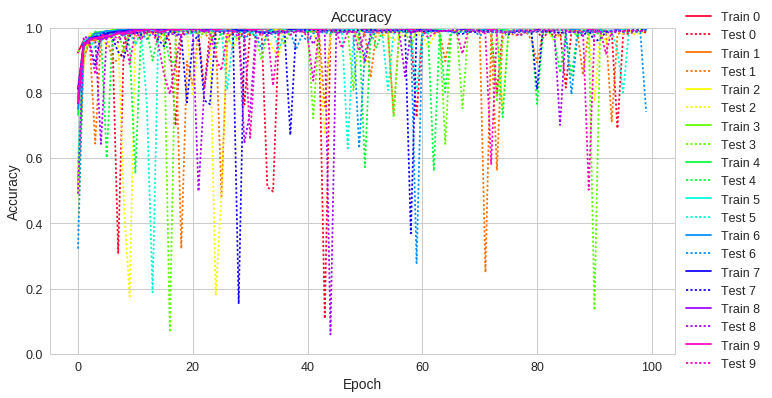

In [27]:
plot_acc(history)

In [28]:
def plot_loss(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['loss'], label='Train '+str(i), color=color, linestyle = 'solid')
        plt.plot(history[i].history['val_loss'], label='Test '+str(i), color=color, linestyle = 'dotted')
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

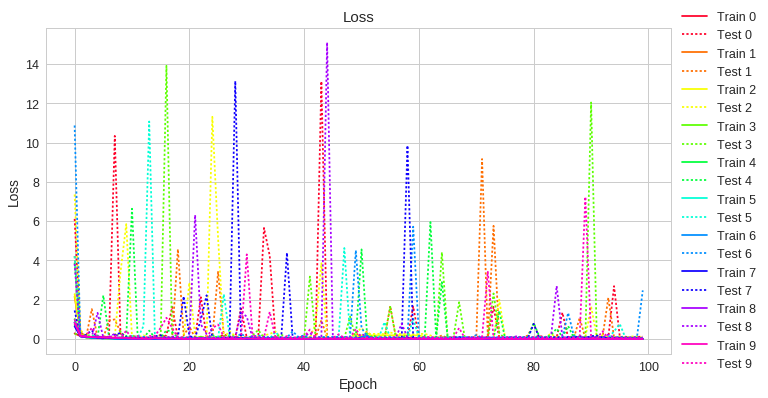

In [29]:
plot_loss(history)

Plotting the confusion matrix


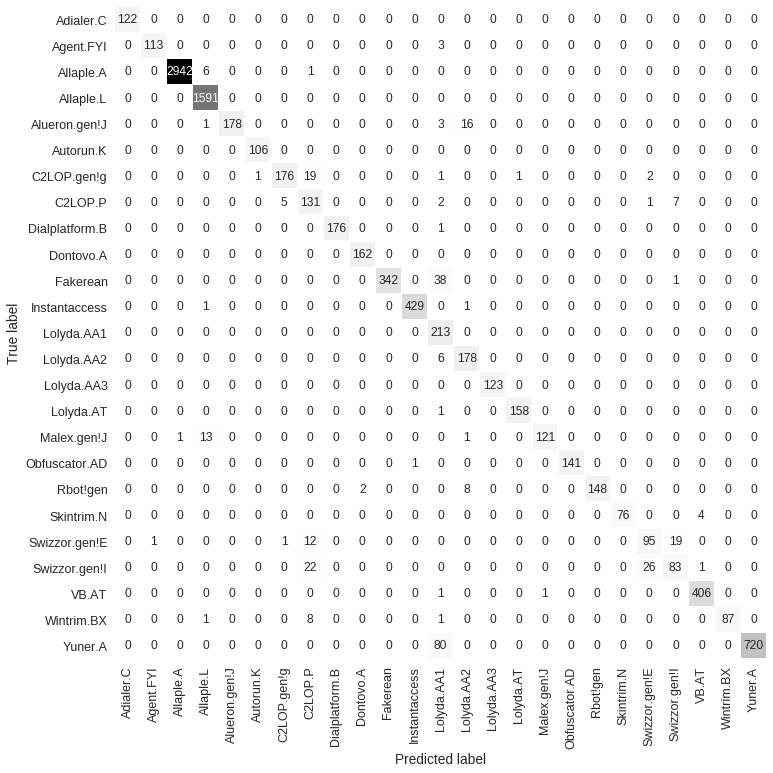

In [30]:
import seaborn as sns

print("Plotting the confusion matrix")
figure = plt.gcf()
figure.set_size_inches(16, 12)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat, cbar=False, annot=True, square=True,
                 fmt='.0f', annot_kws={'size': 12}, linewidth = 0.2, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Plotting the confusion matrix normalized


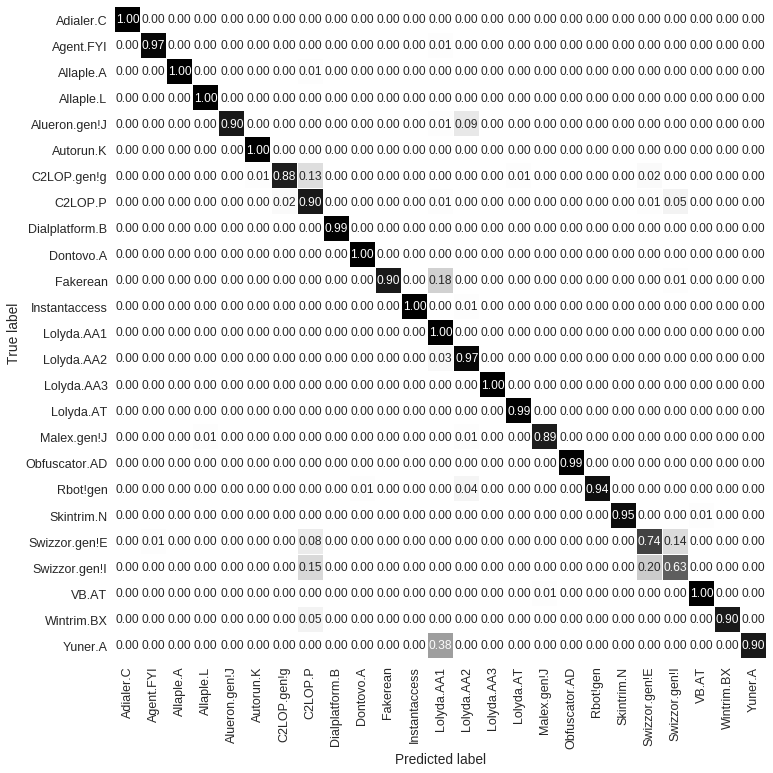

In [31]:
print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/np.sum(conf_mat,axis=1)  # Normalizing the confusion matrix
conf_mat_norm = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure

figure = plt.gcf()
figure.set_size_inches(16, 12)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat_norm, cbar=False, annot=True, square=True,
                 fmt='.2f', annot_kws={'size': 12}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [32]:
for h in history:
    print(h.history)

{'acc': [0.92363593042649517, 0.96104360258746835, 0.96914462711460569, 0.9841553490588516, 0.9854658088827235, 0.98522754345503705, 0.9914224445748846, 0.9854658088827235, 0.9798665713604956, 0.99237550631403382, 0.99702168212551601, 0.99511555870402446, 0.98665713604955918, 0.99594948770092706, 0.99690254944007628, 0.997855611150822, 0.99702168215391951, 0.98594233976649992, 0.99535382416011442, 0.99583035501548722, 0.9986895401477246, 0.99571122230164399, 0.98772933047414824, 0.99368596613790583, 0.99523469144627119, 0.99845127469163464, 0.99416249702168213, 0.9986895401477246, 0.99773647843697877, 0.99654515129854659, 0.99845127472003814, 0.99952346914462709, 0.99964260185847031, 0.99404336430783891, 0.99249463902787705, 0.99678341672623305, 0.99928520371694063, 0.99928520371694063, 1.0, 1.0, 0.9991660710030974, 0.99618775315701691, 0.99857040743388137, 0.99618775312861352, 0.99285203716940673, 0.9986895401477246, 0.99797474386466523, 0.9986895401477246, 1.0, 1.0, 1.0, 1.0, 1.0, 1.

In [33]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0].history['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['acc']
    test_scores = np.zeros((len(history),len(history[0].history['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_acc']
    epochs = np.linspace(0, len(history[0].history['acc']), len(history[0].history['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.show()

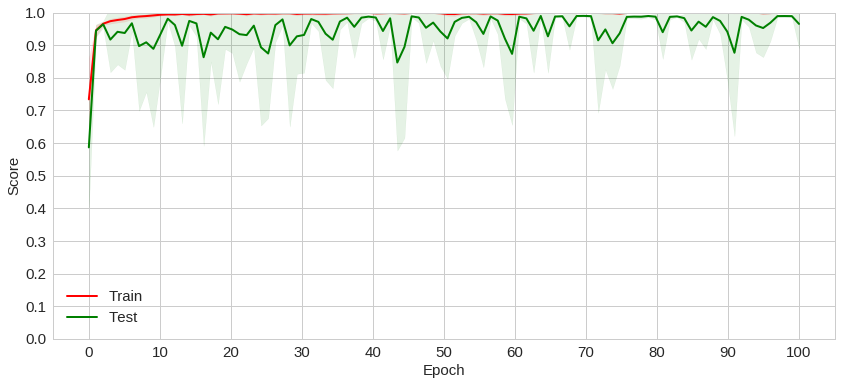

In [34]:
plot_mean_acc(history)

In [35]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0].history['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['loss']
    test_scores = np.zeros((len(history),len(history[0].history['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_loss']
    epochs = np.linspace(0, len(history[0].history['loss']), len(history[0].history['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    plt.show()

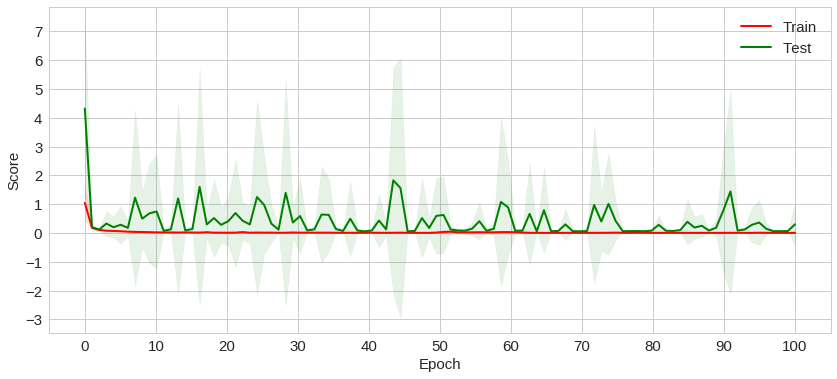

In [36]:
plot_mean_loss(history)

In [37]:
hist = [{'acc': [0.92363593042649517, 0.96104360258746835, 0.96914462711460569, 0.9841553490588516, 0.9854658088827235, 0.98522754345503705, 0.9914224445748846, 0.9854658088827235, 0.9798665713604956, 0.99237550631403382, 0.99702168212551601, 0.99511555870402446, 0.98665713604955918, 0.99594948770092706, 0.99690254944007628, 0.997855611150822, 0.99702168215391951, 0.98594233976649992, 0.99535382416011442, 0.99583035501548722, 0.9986895401477246, 0.99571122230164399, 0.98772933047414824, 0.99368596613790583, 0.99523469144627119, 0.99845127469163464, 0.99416249702168213, 0.9986895401477246, 0.99773647843697877, 0.99654515129854659, 0.99845127472003814, 0.99952346914462709, 0.99964260185847031, 0.99404336430783891, 0.99249463902787705, 0.99678341672623305, 0.99928520371694063, 0.99928520371694063, 1.0, 1.0, 0.9991660710030974, 0.99618775315701691, 0.99857040743388137, 0.99618775312861352, 0.99285203716940673, 0.9986895401477246, 0.99797474386466523, 0.9986895401477246, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98951632118179655, 0.99654515129854659, 0.99833214200619491, 0.99964260185847031, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99154157731713133, 0.99571122230164399, 0.9986895401477246, 0.99940433643078386, 0.9991660710030974, 0.99964260185847031, 1.0, 1.0, 0.99964260185847031, 0.99642601858470337, 0.99833214200619491, 0.99833214200619491, 0.99940433643078386, 0.99988086728615677, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99880867286156783, 0.99428162973552536, 0.9986895401477246, 0.9991660710030974, 0.99988086728615677, 0.99964260185847031], 'loss': [0.28402745473152657, 0.1441692605202812, 0.098540738239184938, 0.042200193462550752, 0.046547124393538176, 0.041315086285788047, 0.028207689118698063, 0.053561318337327954, 0.068949394015480378, 0.024022606557844463, 0.009060171899203346, 0.014725291054267269, 0.045592399626372931, 0.013046221209781288, 0.012032104128426053, 0.0068267238539146966, 0.0097484464345053423, 0.086763100106888674, 0.015574111958389213, 0.015304914435929507, 0.0053378308327078862, 0.012960136235897757, 0.069773290402444482, 0.019244023419184131, 0.014350839116451955, 0.0062662143502297462, 0.020882745501894028, 0.0052710957803886477, 0.0058608578120356953, 0.010273650777223859, 0.0059209368042534389, 0.0016109103159316815, 0.0006900132891102549, 0.018847924990497436, 0.031747029276182712, 0.011852940583560729, 0.0023617784825233201, 0.0012169377328121427, 0.00015419516470233273, 0.00027317568622152688, 0.0024202227816760014, 0.012753751259407234, 0.0060852596865414391, 0.01423203979837556, 0.027923785644946256, 0.0032645495941789082, 0.0049782586658913787, 0.003322455822672358, 0.00020931309120500403, 0.00010589949568409031, 0.00017203691492050536, 4.4372148339864617e-05, 2.7451752472608639e-05, 3.6106743466970628e-05, 1.4644423122699759e-05, 1.6383452232156158e-05, 2.7058600962720272e-05, 1.0208371839166499e-05, 1.4460368372457223e-05, 0.038818836954119515, 0.015612990907173037, 0.0050136658143028461, 0.0014297885604683586, 0.00020148827223271558, 0.00013192807548693616, 5.1609848016727837e-05, 0.00010451089890682551, 3.6571029054531939e-05, 2.8843941941649264e-05, 1.4793624808087498e-05, 1.6281023904744631e-05, 3.2159770242587689e-05, 1.2588698269052821e-05, 0.033505693967255258, 0.013655904535747132, 0.0066061295479859783, 0.0015354840390298756, 0.003135826933966193, 0.0012721492040758378, 0.00017687999157857219, 0.00016587705780163312, 0.0013673517957314141, 0.013751309818902406, 0.0043329670630376273, 0.0058356292238402486, 0.0030774469302563617, 0.001043925382884145, 0.00013888991341583332, 8.1518362042673918e-05, 2.3903210443227075e-05, 0.00012985913787300128, 3.709185404214261e-05, 1.3825633806157657e-05, 2.0806439988973905e-05, 0.0065776847415847791, 0.023180649245901283, 0.0082138594371177452, 0.0031203383172733975, 0.00057765010411388426, 0.00091907270373596571], 'val_acc': [0.50158730158730158, 0.93544973544973542, 0.96296296296296291, 0.98518518518518516, 0.96931216931216935, 0.97777777777777775, 0.97248677248677251, 0.30899470899470899, 0.95767195767195767, 0.982010582010582, 0.97460317460317458, 0.96931216931216935, 0.98306878306878309, 0.98730158730158735, 0.98518518518518516, 0.98624338624338626, 0.95873015873015877, 0.69947089947089947, 0.98095238095238091, 0.982010582010582, 0.98730158730158735, 0.98306878306878309, 0.81164021164021161, 0.98941798941798942, 0.99153439153439149, 0.99047619047619051, 0.96825396825396826, 0.98518518518518516, 0.98835978835978833, 0.76402116402116405, 0.98624338624338626, 0.98835978835978833, 0.98730158730158735, 0.51111111111111107, 0.49735449735449733, 0.98306878306878309, 0.98730158730158735, 0.99047619047619051, 0.99153439153439149, 0.98730158730158735, 0.98624338624338626, 0.98835978835978833, 0.98412698412698407, 0.10793650793650794, 0.98624338624338626, 0.98624338624338626, 0.98730158730158735, 0.98835978835978833, 0.98835978835978833, 0.98941798941798942, 0.99047619047619051, 0.99047619047619051, 0.99047619047619051, 0.99047619047619051, 0.99047619047619051, 0.99153439153439149, 0.99047619047619051, 0.99153439153439149, 0.99047619047619051, 0.72592592592592597, 0.99259259259259258, 0.99047619047619051, 0.99047619047619051, 0.99047619047619051, 0.98941798941798942, 0.99047619047619051, 0.99047619047619051, 0.98941798941798942, 0.99047619047619051, 0.98941798941798942, 0.99047619047619051, 0.98941798941798942, 0.98941798941798942, 0.80000000000000004, 0.98835978835978833, 0.98835978835978833, 0.99153439153439149, 0.98518518518518516, 0.98835978835978833, 0.98730158730158735, 0.98730158730158735, 0.96825396825396826, 0.98730158730158735, 0.97354497354497349, 0.98730158730158735, 0.81587301587301586, 0.99153439153439149, 0.99153439153439149, 0.99153439153439149, 0.99153439153439149, 0.99153439153439149, 0.99153439153439149, 0.99153439153439149, 0.98941798941798942, 0.69100529100529096, 0.98095238095238091, 0.98095238095238091, 0.98730158730158735, 0.98835978835978833, 0.98518518518518516], 'val_loss': [6.1129965000840087, 0.35655834391225305, 0.094413339467214016, 0.073779823027442071, 0.10103977600881885, 0.066135377529190492, 0.13277230476593566, 10.337116681740428, 0.16782585680327702, 0.057946665626309971, 0.15631687020458707, 0.1021987656539514, 0.07127837826114547, 0.053150207385880534, 0.064259940319480222, 0.067782700412490585, 0.18720205350217353, 1.6340901034451811, 0.066950852962074606, 0.091328071458160978, 0.072096328414161026, 0.0682029440484931, 2.1248608717615829, 0.070680780376211186, 0.045786302572318291, 0.05612254222402531, 0.2320542458326455, 0.13089054552282223, 0.084475991968037359, 1.5492922291869209, 0.062380601497506939, 0.065560176360047018, 0.083742262414561897, 5.6525954554320679, 4.2384036374470586, 0.090605843330922656, 0.064571816228355783, 0.053369659189644966, 0.054873820325322252, 0.081190616319296555, 0.11441532986164164, 0.085426588135244938, 0.073234099221090906, 13.113929603213355, 0.067517957493731878, 0.069798215589737575, 0.070064707143233887, 0.068893925116844792, 0.075414469413185206, 0.07409331468734795, 0.079858113770313183, 0.079361746301423744, 0.080746340043092904, 0.080958862185336156, 0.081999123719621772, 0.083140307310282102, 0.080715563006485552, 0.082128593625279259, 0.082339688495186594, 1.6570735136983328, 0.040922109650826995, 0.070834987283440509, 0.062028236645215971, 0.06926550869703034, 0.080542099478809984, 0.079877830161639796, 0.084696634110276003, 0.088566290553612273, 0.088315249131130188, 0.089678556322514966, 0.095022375557731326, 0.10200727203948322, 0.10044348711381916, 1.6349830856132246, 0.046254013623830234, 0.057259558132760978, 0.047870252732136638, 0.079680577877562692, 0.080730330213468773, 0.08429398538207411, 0.090599362819852189, 0.14960887374778351, 0.099899735315777505, 0.11066787619682959, 0.083763067114674308, 1.3428340533655232, 0.069696866346273534, 0.064623626034299442, 0.065123969308842081, 0.07341114283755705, 0.0617960975748615, 0.0651190159605569, 0.062936906394589945, 0.090515830946443609, 2.690482431924754, 0.10716075541995188, 0.11453823688231425, 0.072314968713906788, 0.095177467716254405, 0.13027555264989013]},
{'acc': [0.51065856864285697, 0.90234607597951655, 0.96129570094491668, 0.96153388114802907, 0.96915565085606981, 0.96594021684345188, 0.98570918185066092, 0.98487555079194955, 0.99106823867085969, 0.98868643563177327, 0.99261641062284145, 0.99261641062284145, 0.99380731213528639, 0.99678456591639875, 0.99702274621888765, 0.99749910682386567, 0.99654638561390974, 0.99642729556204179, 0.99642729546266529, 0.99440276289150886, 0.99654638561390974, 0.99106823865666305, 0.99714183637013221, 0.99916636894128852, 0.99892818863879962, 0.99297368107657502, 0.99630820531142072, 0.99904727888942058, 0.99833273788257715, 0.99773728712635468, 0.99761819697511012, 0.99880909848755506, 0.99940454924377753, 1.0, 0.99964272954626654, 0.99356913183279738, 0.99761819697511012, 0.99952363939502198, 0.99976181969751099, 0.99976181969751099, 1.0, 1.0, 1.0, 0.99440276289150886, 0.99678456591639875, 0.99892818863879962, 1.0, 0.99988090984875555, 0.99988090984875555, 0.99928545909253308, 0.99547457425270935, 0.9969036560676432, 0.9984518280338216, 0.99940454924377753, 0.99880909848755506, 0.99416458258901985, 0.99904727879004407, 0.99976181979688761, 0.99940454924377753, 0.99833273788257715, 0.99988090984875555, 1.0, 0.99928545909253308, 0.99797546742884369, 0.99952363939502198, 0.99880909848755506, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9984518280338216, 0.99523639404959685, 0.99761819707448673, 0.99880909848755506, 0.99988090984875555, 0.99726092662075327, 0.99761819697511012, 0.99749910692324228, 0.99654638561390974, 0.99726092652137666, 0.99809455758008814, 0.99869000833631061, 1.0, 0.99940454924377753, 0.99964272954626654, 0.99988090984875555, 0.99964272954626654, 0.9984518280338216, 0.99892818863879962, 0.99880909848755506, 0.99904727879004407, 0.99988090984875555, 0.99904727879004407, 0.99821364783070921, 0.99880909848755506, 0.99916636894128852, 0.99940454924377753, 0.99976181969751099, 1.0], 'loss': [2.1573292747116861, 0.32675211255970887, 0.12631635508949562, 0.11505757842860194, 0.089080267543556774, 0.10243197307886787, 0.046997527036551023, 0.043585350510882893, 0.031409691919376224, 0.0327088830420166, 0.025355620071750209, 0.025341698392223919, 0.023998917031674852, 0.012065343262530229, 0.01000130902091557, 0.0083926068850213101, 0.0097776676622749314, 0.010127936695036614, 0.010337706029294126, 0.01813926756745237, 0.013183577189036646, 0.029914358108394361, 0.0065410178455862457, 0.0036820340277546283, 0.0031607501211714413, 0.025015146647906876, 0.0139401512293336, 0.0033826167471446779, 0.006019516919773483, 0.0085730847558656443, 0.0059458038420020422, 0.0035253934546103328, 0.0015425101922046534, 0.00017134091341521583, 0.00071120535720399372, 0.020546999614590715, 0.0065622952050849595, 0.0017192002167296981, 0.0010510231492434075, 0.0010568376454258011, 0.00026223132352547619, 5.6316473894073587e-05, 0.00028023341450602012, 0.021885053534630178, 0.0080807111344504585, 0.0040588900563837725, 0.00041050390800432922, 0.00032331327186370856, 0.00025965151561473901, 0.0020557304939677118, 0.011775931250114741, 0.01015586943735859, 0.0045775400950323853, 0.0022294711833760459, 0.0037027397115496907, 0.024919157690855048, 0.0034740058281429479, 0.00051594930196730319, 0.0031719286391991932, 0.0042710684139637533, 0.00056770528837878456, 0.00015848165567220894, 0.0017235201573851916, 0.007498278535443049, 0.0031648549226823432, 0.0059381524524977133, 0.00024751474842666488, 0.00011463061741448451, 9.3807106001062818e-05, 3.8823943421934017e-05, 2.7080132025084158e-05, 0.007910044364390292, 0.016586505758711918, 0.0093865738360756241, 0.0058224035997984031, 0.00069218794099228315, 0.0096017704476723965, 0.03073936247104701, 0.034023060285071106, 0.012653980065135869, 0.0087240653216184728, 0.0051706990312558147, 0.0050083055616025191, 0.00020612803102172542, 0.0012640950956723171, 0.0022557123210677518, 0.00078435823543246722, 0.0011967608986088662, 0.0044082913586705507, 0.0034920133461993617, 0.0027122905560908266, 0.0020186911833238227, 0.00033458535502090496, 0.0050049001596870271, 0.0073046365094398252, 0.0024913668240044277, 0.0038043984304301343, 0.0011637725016907642, 0.00042087970685602584, 0.00013930016956303107], 'val_acc': [0.53821656050955413, 0.95116772823779194, 0.96709129511677283, 0.64437367303609339, 0.97027600849256901, 0.97346072186836519, 0.9002123142250531, 0.89702760084925692, 0.93842887473460723, 0.98407643312101911, 0.9861995753715499, 0.98407643312101911, 0.98726114649681529, 0.9861995753715499, 0.97983014861995754, 0.9575371549893843, 0.98089171974522293, 0.98938428874734607, 0.32271762208067939, 0.89702760084925692, 0.82165605095541405, 0.9861995753715499, 0.98407643312101911, 0.96390658174097665, 0.98726114649681529, 0.48195329087048833, 0.96072186836518048, 0.98832271762208068, 0.98832271762208068, 0.97027600849256901, 0.9851380042462845, 0.98938428874734607, 0.98832271762208068, 0.9851380042462845, 0.98938428874734607, 0.98089171974522293, 0.98938428874734607, 0.98938428874734607, 0.99044585987261147, 0.98726114649681529, 0.99044585987261147, 0.99044585987261147, 0.98938428874734607, 0.7579617834394905, 0.9861995753715499, 0.98832271762208068, 0.98938428874734607, 0.9861995753715499, 0.99044585987261147, 0.96496815286624205, 0.98407643312101911, 0.84713375796178347, 0.98938428874734607, 0.97664543524416136, 0.98726114649681529, 0.73673036093418254, 0.98726114649681529, 0.98938428874734607, 0.98832271762208068, 0.98726114649681529, 0.99044585987261147, 0.98938428874734607, 0.98301486199575372, 0.98938428874734607, 0.89702760084925692, 0.98832271762208068, 0.98938428874734607, 0.99150743099787686, 0.99044585987261147, 0.99044585987261147, 0.99044585987261147, 0.2494692144373673, 0.98195329087048833, 0.56263269639065816, 0.99044585987261147, 0.98938428874734607, 0.97558386411889597, 0.97770700636942676, 0.98938428874734607, 0.96284501061571126, 0.89278131634819535, 0.9851380042462845, 0.98726114649681529, 0.99044585987261147, 0.96921443736730362, 0.99256900212314225, 0.99044585987261147, 0.98938428874734607, 0.85456475583864122, 0.99363057324840764, 0.98195329087048833, 0.99150743099787686, 0.98726114649681529, 0.71231422505307851, 0.97876857749469215, 0.98938428874734607, 0.98938428874734607, 0.99044585987261147, 0.98832271762208068, 0.99044585987261147], 'val_loss': [4.2228300075643528, 0.17599910430989113, 0.086085623785131168, 1.5207728670401828, 0.070527359560681235, 0.058771589590513804, 0.95060544944422798, 0.99406092810160784, 0.34791360713241076, 0.046300909046977506, 0.043800703134136115, 0.089562300032938566, 0.028424678002132858, 0.044003278947779625, 0.074311520081319957, 0.21672919055625112, 0.085122549613735859, 0.031107692025989356, 4.5732601749416117, 0.18556139624792439, 0.63198968680361778, 0.059305882106636322, 0.040031810888778864, 0.11253648273499892, 0.059459936660802536, 3.4208567293653473, 0.16076795372003905, 0.041735398914217771, 0.04313921232371011, 0.16595478920711679, 0.078878452072821598, 0.045350820298625978, 0.046271593360103343, 0.046489446489700256, 0.073976138061878471, 0.096944058877360809, 0.028891163249084837, 0.02553830151526456, 0.027270835952374988, 0.036894639983122535, 0.0520136163567161, 0.045057990907832066, 0.054025917360460453, 0.96055469187382647, 0.040095548039143225, 0.036666279723607725, 0.037190049426755238, 0.053574986166234406, 0.047108768332051486, 0.30445229889768466, 0.063459795617305581, 0.39268189948151033, 0.047540296928582311, 0.075819679317853009, 0.04609980734830469, 1.6813410729130744, 0.049268239895229479, 0.047277396054736187, 0.04708219882440106, 0.051984629082807279, 0.037432370941742753, 0.042421170100708505, 0.06611839178885795, 0.037340006722244225, 0.18139460977839522, 0.038934412191578123, 0.042438663425713834, 0.041499884493368187, 0.043046159987625982, 0.045289754965047987, 0.044066534815771261, 9.1606721374148901, 0.084723541163577262, 5.758700474263752, 0.025776110612726499, 0.033164227669729603, 0.090884504598621102, 0.10442892829134447, 0.038110124623597315, 0.1859696662716728, 0.76557592938318075, 0.048691863538145141, 0.049627408367620064, 0.035973252173999382, 0.15802011378183956, 0.027804510478064783, 0.036652164977300505, 0.047091688694598545, 1.0778029908395153, 0.033180490495710258, 0.10664750757804091, 0.064815043144553705, 0.10053691654251128, 2.1037261121541024, 0.08108730097426492, 0.067832757965378312, 0.054812506862160701, 0.048308117336898194, 0.049260545584916458, 0.06307999071055824]},
{'acc': [0.49553624581274652, 0.92631829544811384, 0.97452684204261397, 0.98000238066896794, 0.98297821687894293, 0.98892988929889303, 0.99321509344125702, 0.99345316046576404, 0.99131055826687298, 0.98952505654088796, 0.99559576240923697, 0.99559576240923697, 0.99702416379002501, 0.99476252827044398, 0.99595286275443395, 0.99416736102844905, 0.997857397928818, 0.99916676586120701, 0.99976193310320205, 0.99988096655160097, 0.99773836448041897, 0.99630996309963105, 0.99845256517081304, 0.99952386620640399, 0.99035829067968095, 0.994405427925247, 0.99845256517081304, 0.99880966551601003, 0.99928579930960604, 0.99964289965480302, 1.0, 1.0, 0.99869063206761099, 0.99642899654802997, 0.99381026068325196, 0.99750029758362102, 0.99869063206761099, 0.99976193310320205, 1.0, 1.0, 1.0, 0.99952386620640399, 0.99833353172241401, 0.99773836448041897, 0.99476252827044398, 0.99892869896440895, 0.99916676586120701, 1.0, 1.0, 0.98988215688608494, 0.98619211999281098, 0.98654922033091297, 0.98845375550529702, 0.98773955481490294, 0.987977621711701, 0.98607308653731696, 0.98690632067610995, 0.98833472205689799, 0.98845375550529702, 0.98857278895369594, 0.98833472205689799, 0.98821568860849895, 0.99809546482561595, 0.99928579930960604, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99059635757647901, 0.99714319723842404, 0.99916676586120701, 1.0, 0.99988096655160097, 1.0, 1.0, 1.0, 0.99940483275800496, 0.99750029758362102, 0.99821449827401498, 0.99964289965480302, 1.0, 1.0, 1.0, 0.99988096655160097, 0.99845256517081304, 0.99797643137721703, 0.99761933103202005, 0.99964289965480302, 0.99928579930960604, 0.99952386620640399, 0.99988096655160097, 0.99880966551601003, 0.99940483275800496, 0.99964289965480302], 'loss': [2.284565931036421, 0.23685007819784154, 0.076549558433859397, 0.055599911144845131, 0.052122634177318682, 0.030923891088434973, 0.022256159343481918, 0.020248523848693353, 0.021827792459966942, 0.034171310948856941, 0.012250846924043031, 0.01265756728826645, 0.0098976688980966423, 0.014909144616587698, 0.011589038905288762, 0.021078938138562025, 0.0065794165107910156, 0.0026881005981357442, 0.0008896402787547114, 0.00066525050537338739, 0.0078349566025853138, 0.011332663850457367, 0.0063400695976430837, 0.0014166223367214599, 0.047192063679865684, 0.019376236598784555, 0.0045444176314867633, 0.003440594968353364, 0.0026796127336596374, 0.0011762353307194723, 0.00027814284421707016, 0.00025989667079431817, 0.0044906715399541074, 0.011886793016802224, 0.024850658722799811, 0.0092836919965786132, 0.0049458424229516752, 0.0014567772214015685, 0.00017324114087594847, 9.20146932807258e-05, 0.00021177885408302187, 0.0014432509820689831, 0.0052320239052938075, 0.0086133634005977674, 0.019518821248626653, 0.0039833383342470297, 0.0016132658150905166, 0.00022586766660248335, 0.00010475010885944511, 0.1106467366335163, 0.19334266456310137, 0.18833992424995041, 0.18298402129154842, 0.18474134509496004, 0.18662306824086303, 0.18781693238280933, 0.18956407715605006, 0.18396131555029022, 0.18264989240946194, 0.18267788202805504, 0.18351182788500833, 0.1031763580221164, 0.0044602404469841856, 0.0016810148685445852, 0.00022718127700969173, 0.00010368489273687927, 5.4183398343096538e-05, 6.7761904986024654e-05, 2.3089821904916795e-05, 1.6734881100258854e-05, 2.7270288514163686e-05, 9.7195729490766473e-06, 1.8242122959571072e-05, 2.184910253352444e-05, 0.045360677255349244, 0.011764767310156892, 0.0022462131881620414, 0.0004186273743033551, 0.00031099131170610384, 0.00011996434605100044, 6.6779472102122795e-05, 4.774034691118828e-05, 0.0017114796538521538, 0.0087098658344290491, 0.0078796306399937597, 0.00059841704609907916, 0.00016772773957563221, 7.8772059335616197e-05, 4.7381660061645917e-05, 0.00019751248026109806, 0.0071780480147890426, 0.0095657072753556182, 0.015095456463267992, 0.00090118425858306671, 0.0024410508004987972, 0.00085558221595930645, 0.002151327871218483, 0.0062555622842036408, 0.0027512628121797011, 0.00072683075594218009], 'val_acc': [0.37633262260127931, 0.8987206823027718, 0.98187633262260132, 0.98187633262260132, 0.9850746268656716, 0.94243070362473347, 0.98187633262260132, 0.97761194029850751, 0.45948827292110872, 0.17590618336886993, 0.98720682302771856, 0.98187633262260132, 0.96375266524520253, 0.98827292110874199, 0.95735607675906187, 0.98614072494669514, 0.98614072494669514, 0.99147121535181237, 0.98933901918976541, 0.98614072494669514, 0.79104477611940294, 0.95522388059701491, 0.98720682302771856, 0.98827292110874199, 0.17910447761194029, 0.48720682302771856, 0.9850746268656716, 0.93176972281449888, 0.97974413646055436, 0.98827292110874199, 0.98933901918976541, 0.98827292110874199, 0.97761194029850751, 0.96695095948827292, 0.93283582089552242, 0.91577825159914716, 0.9925373134328358, 0.98933901918976541, 0.99040511727078895, 0.99147121535181237, 0.9925373134328358, 0.99147121535181237, 0.91791044776119401, 0.67377398720682302, 0.99147121535181237, 0.98720682302771856, 0.9925373134328358, 0.9925373134328358, 0.99360341151385922, 0.95948827292110872, 0.87633262260127931, 0.97654584221748397, 0.97547974413646055, 0.97547974413646055, 0.97867803837953093, 0.96055437100213215, 0.9733475479744137, 0.97761194029850751, 0.97547974413646055, 0.97974413646055436, 0.97761194029850751, 0.93923240938166308, 0.9733475479744137, 0.99147121535181237, 0.98933901918976541, 0.99040511727078895, 0.99040511727078895, 0.98933901918976541, 0.99040511727078895, 0.99040511727078895, 0.99147121535181237, 0.99147121535181237, 0.99147121535181237, 0.99040511727078895, 0.75692963752665243, 0.98294243070362475, 0.98614072494669514, 0.9925373134328358, 0.9925373134328358, 0.9925373134328358, 0.99040511727078895, 0.99147121535181237, 0.9850746268656716, 0.95735607675906187, 0.98827292110874199, 0.99147121535181237, 0.98933901918976541, 0.98933901918976541, 0.98933901918976541, 0.98827292110874199, 0.77398720682302768, 0.98400852878464817, 0.95522388059701491, 0.9850746268656716, 0.98827292110874199, 0.98081023454157779, 0.99040511727078895, 0.97974413646055436, 0.98294243070362475, 0.98933901918976541], 'val_loss': [7.3568931388448338, 0.48100834010380378, 0.072727109566959602, 0.064525008331694195, 0.055708764844048679, 0.14902987491197625, 0.094907763529700456, 0.080435705203210195, 3.4118778478817893, 5.8492820972064408, 0.068625075927730692, 0.07337831941369706, 0.18664567987842676, 0.075399430582361912, 0.14164832589174103, 0.073109525216686788, 0.09073096167582656, 0.056772824739400415, 0.06691457730238308, 0.06473171506921005, 2.8723792709160727, 0.14978382046870745, 0.080217546214191512, 0.054213167682761826, 11.307776106179936, 5.1375567556462673, 0.082522938140577026, 0.39369750501631035, 0.13959691720434467, 0.063847615522781287, 0.066911634274550283, 0.057965724617317083, 0.14547357767243582, 0.17553734883966882, 0.25744110641243717, 0.38042724593636151, 0.051348607327864358, 0.052664408811988243, 0.050502912033331383, 0.050614251520538674, 0.062738224721833658, 0.057418008030318129, 0.77660511243473684, 3.857377197155091, 0.039506020863581043, 0.07946124216106483, 0.045284158800835694, 0.047893791817338625, 0.049211633737952107, 0.31334839786498075, 0.55922885184500515, 0.25767983957287838, 0.25758321234392706, 0.26272991957616015, 0.24515876355893793, 0.32928565663357234, 0.25427247569339756, 0.25335442529014462, 0.2567087897983481, 0.23100145253360507, 0.25491308428945136, 0.26006651845407591, 0.17820992762069504, 0.081170304842337754, 0.0638405418441617, 0.063135970764615287, 0.06011886701503466, 0.051841133198948224, 0.058092418321686268, 0.058266813252018018, 0.059557356248342776, 0.060894908302106483, 0.057932145373490326, 0.059616419808148385, 1.9998842765123404, 0.078952178889632935, 0.064446418117591386, 0.050412692047379935, 0.053021197093756502, 0.051624625722340237, 0.053754907729014541, 0.051192723040390839, 0.099905960878737585, 0.26472519341892553, 0.077128665059771839, 0.058041829642959779, 0.060773147195234495, 0.062874548898642676, 0.061342750091998896, 0.077671291400451509, 1.6546191986617511, 0.10069519686843864, 0.18570867321859386, 0.10329551357702113, 0.086707490920336625, 0.12667221527314268, 0.0716186464174242, 0.12515289801465809, 0.12720781415681265, 0.061298836096442703]},
{'acc': [0.79590622396763056, 0.95799119367097851, 0.96703558253004884, 0.968106628634682, 0.97596096632155183, 0.97667499702487204, 0.98024515054147332, 0.98357729382363446, 0.99012257527073666, 0.99416874925621801, 0.98809948827799599, 0.99500178507675829, 0.99583482089729858, 0.99404974418865077, 0.99452576465753095, 0.99523979531119833, 0.99285969296679755, 0.98905152921575623, 0.9980959181244794, 0.99642984648339883, 0.99821492324169936, 0.99678686183505893, 0.99047959062239677, 0.9969058669522789, 0.99928596929667979, 0.99797691300725933, 0.9984529334761395, 0.99488278000919106, 0.9984529334761395, 0.99571581578007851, 0.99928596929667979, 0.99904795906223964, 0.99583482089729858, 0.9984529334761395, 0.99714387718671904, 0.9980959181244794, 0.99523979531119833, 0.9984529334761395, 0.99773890277281918, 0.99916696417945972, 0.99880994882779961, 0.99928596929667979, 0.99880994882779961, 0.99904795906223964, 0.9980959181244794, 0.9980959181244794, 0.99857193859335946, 0.99916696417945972, 0.99857193859335946, 0.99738188742115907, 0.99726288230393911, 0.99952397953111982, 0.99821492324169936, 0.99940497441389975, 0.99928596929667979, 0.99833392835891943, 0.99773890277281918, 1.0, 0.99857193859335946, 0.99785790789003925, 0.99714387723637188, 0.99916696417945972, 0.99976198976555997, 0.99928596929667979, 0.99904795906223964, 0.99738188742115907, 0.99821492324169936, 0.99833392835891943, 0.99904795906223964, 0.99940497441389975, 1.0, 1.0, 1.0, 0.99797691300725933, 0.99571581578007851, 0.99904795906223964, 0.99952397953111982, 0.99988099488277993, 1.0, 1.0, 0.99940497441389975, 0.99964298464833989, 0.9980959181244794, 0.99821492324169936, 0.99964298464833989, 0.99976198976555997, 1.0, 0.99738188742115907, 0.9984529334761395, 0.99988099488277993, 0.99952397953111982, 0.99904795906223964, 0.99952397953111982, 0.99940497441389975, 0.99976198976555997, 1.0, 1.0, 1.0, 1.0, 0.99976198976555997], 'loss': [0.72231703825178817, 0.13855028771352557, 0.11061214372904921, 0.097417000894402944, 0.07399930838926852, 0.070493408716974779, 0.065146932552916523, 0.049755590532263638, 0.027884351083681081, 0.019473476604977804, 0.041909934052898036, 0.017546171138248051, 0.011540836802508989, 0.017666571246152299, 0.016230228375955485, 0.014589407330673815, 0.03532628427866652, 0.071769782811806487, 0.0062606409836011411, 0.011044352463001622, 0.0062145690585721945, 0.0090145029409845739, 0.12168477437269604, 0.010266439067209273, 0.003512773248288113, 0.007577961346470337, 0.0054557509228265353, 0.012630749251132261, 0.0044152745018259405, 0.014129082002705075, 0.0024538502570968443, 0.0030706384333251263, 0.012205730987440218, 0.0039866714518596762, 0.0098714398928739198, 0.0043162855801359649, 0.015974398554221236, 0.0043361084010403866, 0.0074475302399861776, 0.0026029270456661047, 0.0038952471010731695, 0.0023566388001857769, 0.0039761871698376092, 0.003095915120244026, 0.0098968942825875227, 0.006040037725361035, 0.0046118571908649155, 0.002723157094592212, 0.0040070689702520991, 0.0078841259888699569, 0.0097052025267345843, 0.0016083812727247305, 0.0064393427884008201, 0.0024682053406182621, 0.0015104239764617093, 0.0061163491828203484, 0.0066527429883469743, 0.00053702973039854954, 0.0063099977904562858, 0.0055248597268149372, 0.010309735017848237, 0.0025517674813869467, 0.00093556989291961057, 0.0023080707148941519, 0.0033932386347535924, 0.0072783261138920181, 0.005911556956911145, 0.0074132220406007854, 0.0025494849699041803, 0.001469554690362795, 0.00010651658005605292, 6.4283867714462126e-05, 2.3800968169048183e-05, 0.005344940439208635, 0.018308128039845471, 0.0039033314578519221, 0.00077756712752734985, 0.00047709680031050557, 0.00010873221670605851, 9.3900157044273668e-05, 0.0015165246843045043, 0.0015530992937085157, 0.0060775164476699131, 0.0039567608660237919, 0.0010727657354123476, 0.0010892334539074301, 0.00011457283034227099, 0.0068950665718988131, 0.0052826202383215856, 0.00079299171015029398, 0.0029498275733152867, 0.0030381274750647795, 0.0015526402701327299, 0.0015072763012709081, 0.0015193487354865584, 0.00019199495937934617, 5.0434690214065744e-05, 2.4783064353394297e-05, 1.8910763305405191e-05, 0.00074639502940253299], 'val_acc': [0.92735042735042739, 0.93162393162393164, 0.94764957264957261, 0.95512820512820518, 0.95940170940170943, 0.97756410256410253, 0.97756410256410253, 0.99038461538461542, 0.92307692307692313, 0.98717948717948723, 0.94978632478632474, 0.99038461538461542, 0.98824786324786329, 0.99252136752136755, 0.98931623931623935, 0.98824786324786329, 0.06623931623931624, 0.98290598290598286, 0.99358974358974361, 0.98931623931623935, 0.99252136752136755, 0.98076923076923073, 0.97970085470085466, 0.99358974358974361, 0.97756410256410253, 0.97756410256410253, 0.95405982905982911, 0.96901709401709402, 0.96581196581196582, 0.9850427350427351, 0.99465811965811968, 0.96474358974358976, 0.90170940170940173, 0.9850427350427351, 0.99358974358974361, 0.9786324786324786, 0.94764957264957261, 0.99252136752136755, 0.99145299145299148, 0.98717948717948723, 0.99252136752136755, 0.72222222222222221, 0.99358974358974361, 0.98611111111111116, 0.9786324786324786, 0.99038461538461542, 0.99465811965811968, 0.99465811965811968, 0.80769230769230771, 0.99038461538461542, 0.99572649572649574, 0.99038461538461542, 0.99252136752136755, 0.99465811965811968, 0.99252136752136755, 0.7254273504273504, 0.99038461538461542, 0.99252136752136755, 0.9391025641025641, 0.99465811965811968, 0.98931623931623935, 0.99038461538461542, 0.99145299145299148, 0.99465811965811968, 0.64316239316239321, 0.98290598290598286, 0.99358974358974361, 0.75213675213675213, 0.99252136752136755, 0.99145299145299148, 0.99358974358974361, 0.99358974358974361, 0.99358974358974361, 0.77243589743589747, 0.96474358974358976, 0.98931623931623935, 0.99358974358974361, 0.99252136752136755, 0.99572649572649574, 0.99572649572649574, 0.98931623931623935, 0.99252136752136755, 0.98824786324786329, 0.99358974358974361, 0.99145299145299148, 0.99465811965811968, 0.99465811965811968, 0.97329059829059827, 0.99252136752136755, 0.99252136752136755, 0.13354700854700854, 0.99358974358974361, 0.98397435897435892, 0.98824786324786329, 0.99145299145299148, 0.99252136752136755, 0.99358974358974361, 0.99358974358974361, 0.99465811965811968, 0.99145299145299148], 'val_loss': [0.26718632691011457, 0.18166337748537173, 0.18157812722123567, 0.18855116244584771, 0.10452133925307058, 0.066485643380211512, 0.069392684587181716, 0.029570876231863014, 0.39028081528118425, 0.041305820616559852, 0.19522884476431204, 0.026522750039219271, 0.046619208900279638, 0.028354859903499199, 0.02510095573521514, 0.039627580074948536, 13.903384493966389, 0.054606327063596929, 0.028515588988259656, 0.056021354737848784, 0.034211103916025686, 0.056110813419485123, 0.079254877987230327, 0.055310488132141358, 0.093076785504437876, 0.11417592754801223, 0.14834336392144876, 0.15258481792538908, 0.14440375110006873, 0.043246524425626501, 0.016973602264690787, 0.18226073249558375, 0.4590514116101117, 0.055316221219145756, 0.020354458302678118, 0.1244023152491788, 0.22516568914005586, 0.039140010679111645, 0.032247489364097166, 0.037468449880998594, 0.063869495726753434, 3.176173521058705, 0.042067232622599579, 0.063936797452399469, 0.10579640486168705, 0.035988503469957349, 0.053460115649233433, 0.042952672361876977, 1.1365254070189319, 0.032323684506767078, 0.030419193148493284, 0.069275949940495615, 0.037352864097330775, 0.028188925745984753, 0.0296466448321763, 1.6364164180732421, 0.046845038134523106, 0.042266127805215825, 0.24058868555303328, 0.024280520388895034, 0.03641086984522604, 0.05515481069474297, 0.054145890798193166, 0.042309558992933628, 4.411664977293138, 0.078560413787162248, 0.057116515212465649, 1.872543847740529, 0.033504541677413173, 0.044775166259786038, 0.031113127400108562, 0.029752848650012893, 0.031009961431042368, 2.3189385132627427, 0.30510425934687707, 0.016853782840664872, 0.01713018997421762, 0.020290798564423351, 0.031352374602859077, 0.034564446306622781, 0.068624994869716571, 0.087874121986284359, 0.029365201274865391, 0.021063730438376782, 0.039827506134969201, 0.021219076338852734, 0.029510529318351623, 0.21130340174829113, 0.06137181072159361, 0.041262760484704369, 12.037545363108316, 0.023645852299303088, 0.093542013496909715, 0.043491524659640075, 0.079793161666630794, 0.048899012309207783, 0.056656444863025436, 0.052693709317011894, 0.052524376545209417, 0.031025557000886744]},
{'acc': [0.73262732029528577, 0.95728224660600159, 0.96715849595430747, 0.98357924794878404, 0.98726796763445979, 0.98857686812965029, 0.99178962398857684, 0.99345549738219896, 0.99690623512613041, 0.99797715373631601, 0.99250356972870057, 0.99762018086625415, 0.99821513564969067, 0.9978581627796288, 0.99643027129938122, 0.99904807234650161, 0.99500237981913375, 0.99726320799619228, 0.99821513564969067, 0.99916706330318894, 0.99952403617325081, 0.99726320799619228, 0.99702522608281774, 0.99702522608281774, 0.9970252260544481, 0.99607329842931935, 0.99988100904331267, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98810090433127085, 0.9978581627796288, 0.99916706330318894, 1.0, 0.99988100904331267, 1.0, 1.0, 1.0, 1.0, 0.99976201808662546, 0.99988100904331267, 0.98952879581151831, 0.99773917182294147, 0.9989290813898144, 0.99988100904331267, 1.0, 1.0, 1.0, 0.99976201808662546, 0.99988100904331267, 1.0, 0.99976201808662546, 0.99393146120894815, 0.99607329842931935, 0.99773917182294147, 0.99857210851975253, 0.99869109947643975, 0.99976201808662546, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99416944312232269, 0.99809614469300334, 0.99976201808662546, 0.99964302712993813, 0.99964302712993813, 0.99928605425987627, 0.99928605425987627, 0.99916706330318894, 0.99988100904331267, 0.99952403617325081, 0.9978581627796288, 0.99916706330318894, 0.9989290813898144, 0.99964302712993813, 0.99976201808662546, 0.99976201808662546, 0.99857210851975253, 0.99678724416944309, 0.99940504521656359, 0.99988100904331267, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'loss': [1.010744366920715, 0.13877997863000488, 0.098422613413361698, 0.050824622418385694, 0.039277830092003238, 0.038991917670194214, 0.029869550541794635, 0.017548233436347198, 0.0097249021840606267, 0.0062058382040407331, 0.023208947912400905, 0.0079993950497077668, 0.0057847819163183972, 0.006012138675149787, 0.009832528712396274, 0.0057020780426958219, 0.014291223494313512, 0.0084913856943469937, 0.005318456321350154, 0.0042759679974165412, 0.0013887711067408111, 0.006505067891745037, 0.0087896440480026757, 0.0086226327544796505, 0.010597892426372572, 0.014041023807381994, 0.00077503248830700197, 0.00036153534012585046, 0.00018723669537190128, 8.5334015113268377e-05, 0.00010567194310508675, 2.9194980700571955e-05, 4.2681382151509432e-05, 9.3189400203080126e-05, 3.4942982479564804e-05, 2.7443578262739736e-05, 5.9972036585775528e-05, 2.021612533537474e-05, 1.6565800979021524e-05, 1.2592585481901329e-05, 0.049051342404806832, 0.0064385861167492757, 0.0028028663809142548, 0.00050383281920569325, 0.00039461430618794961, 0.00012222577046795143, 0.00011939439474414963, 5.7967688841010737e-05, 4.4337941443454091e-05, 0.00047355124317814999, 0.00066063277062605036, 0.044185914236749724, 0.0069077295223432247, 0.0037846336951377641, 0.00063894211340856713, 0.00016426199320999718, 0.00010471848587502284, 0.00011580274373337306, 0.00059491132143359908, 0.0004703374612750154, 7.5722136749202475e-05, 0.00063418348302148552, 0.025305911910439977, 0.022309974568314763, 0.0060022037245248848, 0.0046912865217417351, 0.0039101990004084168, 0.00060796809718657537, 0.00010076054567463337, 5.7237300300088095e-05, 5.0107638538871694e-05, 5.6581942681012703e-05, 4.4536262635823227e-05, 7.8640715983428286e-05, 0.021010236530252538, 0.0056275685952078469, 0.0014364982887601152, 0.00099105071611668835, 0.0010969306784154548, 0.0034821990302819766, 0.0022232165546146663, 0.0026596630264293058, 0.00076240039054101684, 0.00086993464467264041, 0.0074032853220467312, 0.0030188162257222323, 0.0051977387342369537, 0.0017457871002765537, 0.00075064896248428533, 0.00072403330663896163, 0.0070754044963630587, 0.013723783235109043, 0.0020199071953848017, 0.0005458831929453737, 0.00011766557275031253, 3.0000896680784481e-05, 0.00017554939444642907, 3.5246741009930514e-05, 1.4353809421772193e-05, 3.2922011029113801e-05], 'val_acc': [0.54224598930481283, 0.95294117647058818, 0.97005347593582891, 0.9882352941176471, 0.98074866310160425, 0.60106951871657754, 0.97433155080213907, 0.98716577540106953, 0.98181818181818181, 0.94224598930481285, 0.55294117647058827, 0.99251336898395726, 0.99037433155080212, 0.89839572192513373, 0.98074866310160425, 0.98395721925133695, 0.89625668449197859, 0.89304812834224601, 0.98716577540106953, 0.98930481283422456, 0.9850267379679144, 0.98609625668449197, 0.9882352941176471, 0.98930481283422456, 0.9347593582887701, 0.9882352941176471, 0.99037433155080212, 0.9882352941176471, 0.98716577540106953, 0.9882352941176471, 0.9882352941176471, 0.98930481283422456, 0.9882352941176471, 0.98930481283422456, 0.9882352941176471, 0.98716577540106953, 0.9882352941176471, 0.98930481283422456, 0.99037433155080212, 0.98930481283422456, 0.98716577540106953, 0.9882352941176471, 0.99144385026737969, 0.99037433155080212, 0.99037433155080212, 0.99144385026737969, 0.99144385026737969, 0.99144385026737969, 0.99037433155080212, 0.98930481283422456, 0.57219251336898391, 0.99037433155080212, 0.93903743315508026, 0.98716577540106953, 0.9882352941176471, 0.98930481283422456, 0.99037433155080212, 0.99037433155080212, 0.9882352941176471, 0.98930481283422456, 0.99037433155080212, 0.99037433155080212, 0.56042780748663101, 0.98181818181818181, 0.80213903743315507, 0.9850267379679144, 0.98395721925133695, 0.99144385026737969, 0.99037433155080212, 0.99037433155080212, 0.99037433155080212, 0.99144385026737969, 0.99251336898395726, 0.99037433155080212, 0.72513368983957216, 0.9882352941176471, 0.98930481283422456, 0.99037433155080212, 0.98288770053475938, 0.98609625668449197, 0.76577540106951869, 0.97967914438502679, 0.98930481283422456, 0.96470588235294119, 0.86203208556149735, 0.98288770053475938, 0.84919786096256689, 0.9882352941176471, 0.98395721925133695, 0.98716577540106953, 0.97754010695187166, 0.9850267379679144, 0.9882352941176471, 0.99037433155080212, 0.98930481283422456, 0.99037433155080212, 0.99037433155080212, 0.99037433155080212, 0.99037433155080212, 0.99037433155080212], 'val_loss': [3.880794855019944, 0.12355384697756645, 0.080451613811048914, 0.036405641504243635, 0.050281237530955335, 2.2173289674082022, 0.082526291526336087, 0.04524070331278969, 0.055266090479977853, 0.1153049157184154, 6.629683057656063, 0.025051641366607168, 0.038486249944626884, 0.4246873847612947, 0.060373015427374985, 0.056138951046837582, 0.44640459899951201, 0.36392187117269781, 0.058401637361806362, 0.048772465849572122, 0.064978903770651991, 0.056813660993911552, 0.052624793342318996, 0.035514010916244232, 0.20327210606245932, 0.061340855700592826, 0.057099286722203831, 0.046493192777572794, 0.051509434941519223, 0.052119511238236951, 0.051901651774444391, 0.05264952550496927, 0.048686315842479296, 0.050757760394709708, 0.053643634046682882, 0.05736564841051274, 0.052289272218361237, 0.052808682778636012, 0.056402863252487473, 0.056925967633412754, 0.042798831643199489, 0.025996063922169261, 0.027566442689821811, 0.021716922453903487, 0.031611745435401004, 0.031010539811971143, 0.03256199123606697, 0.032875979634395695, 0.034927505629185535, 0.034858896906729782, 4.5610724244600496, 0.028761853892063573, 0.18212299966341142, 0.052083310458733198, 0.04294434790792697, 0.048965784357054502, 0.050222355631484153, 0.055460967470068838, 0.049858304572628902, 0.049477280414371681, 0.051996061200877401, 0.035317088543243239, 5.9496471126298376, 0.071412328973528949, 2.8961003318324408, 0.058130428031140609, 0.10185505224196269, 0.039540089390493451, 0.037280791367012144, 0.037836834573320925, 0.038169381017950199, 0.037897959173082751, 0.038621990878184603, 0.036498060120321085, 1.4315869651902642, 0.039481301848748693, 0.083356670274041353, 0.0380240929567187, 0.072458132147118853, 0.11297276664229788, 0.8155487713167644, 0.11206577662639298, 0.066189790618785035, 0.20449967334209573, 0.53008376803591395, 0.090448765662897945, 0.65881127385199423, 0.05322421516738355, 0.13098682019691882, 0.062885264986856954, 0.12272983369052719, 0.11935432881986013, 0.06926453119573224, 0.045661915519509225, 0.034633569764690064, 0.036907958877952556, 0.044355188474502344, 0.044801586780454497, 0.044328624917519183, 0.041046732460760932]},
{'acc': [0.76653974295116389, 0.95728224652089255, 0.96918134218962182, 0.96882436934792959, 0.982032365540219, 0.98048548310328421, 0.98917182294145645, 0.98988576868158018, 0.99357448831051653, 0.99464540694907189, 0.99321751546882442, 0.99524036173250829, 0.99119466920514043, 0.99250356972870057, 0.9915516420752023, 0.99881009043312707, 0.99916706330318894, 0.99928605425987627, 0.99726320799619228, 0.99714421703950495, 0.99857210851975253, 0.99881009043312707, 1.0, 1.0, 1.0, 1.0, 0.98917182294145645, 0.99309852451213709, 0.99821513564969067, 0.99928605425987627, 0.99857210851975253, 0.99857210851975253, 0.99738219895287961, 0.99762018086625415, 0.99952403617325081, 0.99881009040475743, 0.99571632555925749, 0.99857210851975253, 0.99869109947643975, 0.99988100904331267, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99405045216563537, 0.99500237981913375, 0.99881009043312707, 0.99976201808662546, 1.0, 1.0, 1.0, 0.99976201808662546, 0.99333650642551163, 0.9989290813898144, 0.99988100904331267, 1.0, 0.99702522608281774, 0.99762018086625415, 0.99524036173250829, 0.99904807234650161, 0.99940504521656359, 0.99904807234650161, 0.99952403617325081, 1.0, 0.99940504521656359, 0.99988100904331267, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99238457877201336, 0.99619228944274596, 0.99702522608281774, 1.0, 0.99988100904331267, 0.99988100904331267], 'loss': [0.84394855621398945, 0.13634861204090543, 0.092040130231123438, 0.082160061703589721, 0.048370162563674199, 0.057077500910326651, 0.03212751569008071, 0.026089747919570718, 0.017451911735195363, 0.015520703086937808, 0.019815948898908458, 0.017077979632913277, 0.022773001218479045, 0.02711545411570606, 0.02515156267050209, 0.0035855104250316476, 0.0027366490158566687, 0.0026773607559382826, 0.011296614324048715, 0.00993454629771587, 0.0055921575690897306, 0.0043783814163378849, 0.00043532064253396213, 0.00013036479113833239, 9.6280764810243057e-05, 0.00032204987059385024, 0.045062363901238751, 0.022013833402886079, 0.0055017802637279695, 0.0022157712999282429, 0.0039856978345796431, 0.0054864459693486321, 0.0067614208825343518, 0.0060601017123037724, 0.001960113733297509, 0.003450848804790455, 0.013558693318485233, 0.0041066710973769755, 0.004821383391858159, 0.0004870142739605994, 0.0001163604219648112, 6.825509956034581e-05, 4.4845992310854968e-05, 2.2782131763190395e-05, 2.0663935988730795e-05, 4.7257229443524474e-05, 2.7068112044049927e-05, 0.018460169678293628, 0.016714076354514083, 0.0041134969721403391, 0.0010213985313483175, 0.00056855571117597704, 8.6945529675193546e-05, 8.3703606142301155e-05, 0.00092794837766184738, 0.020508246534690838, 0.002284393881016557, 0.00051251965977776976, 0.00012657913390666693, 0.010213040411874425, 0.0072727302115690269, 0.015745373909205204, 0.002197364742206177, 0.002088649209844997, 0.0032038292674702665, 0.0012763928790983671, 0.00015937363718362388, 0.001005202839936965, 0.0008597674772446121, 0.00010457069869646216, 3.7347759841864416e-05, 2.407820055418153e-05, 1.9002034043206983e-05, 1.7462024130541268e-05, 2.1722633532469198e-05, 6.0460997031982259e-06, 5.5509549766818954e-06, 6.0123997607865618e-06, 5.8327573922392782e-06, 9.8339122889214902e-06, 3.3196862882913226e-06, 5.1668633063922035e-06, 2.7114072292672019e-06, 2.8609818119801243e-06, 3.5841017759438737e-06, 1.6533351007603776e-06, 3.8523813063265053e-06, 8.1477793210863999e-06, 3.4759312150664191e-06, 2.0162131640461995e-06, 3.3077504806646988e-06, 1.4591318086488445e-06, 7.043206757613471e-07, 9.7307216545077249e-07, 0.033564523211053264, 0.013270837320993784, 0.010004533123069434, 0.00044539225602413269, 0.00024633085430387055, 0.00036153413836447434], 'val_acc': [0.58716577540106951, 0.95935828877005347, 0.96577540106951876, 0.93582887700534756, 0.95721925133689845, 0.9850267379679144, 0.97219251336898393, 0.98395721925133695, 0.97860962566844922, 0.98288770053475938, 0.94759358288770057, 0.98716577540106953, 0.76791443850267382, 0.18823529411764706, 0.98716577540106953, 0.99144385026737969, 0.99037433155080212, 0.99358288770053471, 0.99037433155080212, 0.97967914438502679, 0.98288770053475938, 0.99251336898395726, 0.99144385026737969, 0.99144385026737969, 0.99144385026737969, 0.99037433155080212, 0.80962566844919781, 0.96256684491978606, 0.99037433155080212, 0.98930481283422456, 0.99144385026737969, 0.97540106951871652, 0.9850267379679144, 0.98074866310160425, 0.99251336898395726, 0.93368983957219254, 0.98395721925133695, 0.98930481283422456, 0.99251336898395726, 0.98930481283422456, 0.99251336898395726, 0.99465240641711228, 0.99358288770053471, 0.99358288770053471, 0.99144385026737969, 0.99358288770053471, 0.99358288770053471, 0.62994652406417118, 0.97219251336898393, 0.99037433155080212, 0.9882352941176471, 0.99144385026737969, 0.99037433155080212, 0.98930481283422456, 0.80855614973262036, 0.98288770053475938, 0.99037433155080212, 0.99251336898395726, 0.99251336898395726, 0.80534759358288766, 0.99037433155080212, 0.98288770053475938, 0.99251336898395726, 0.99358288770053471, 0.99251336898395726, 0.9850267379679144, 0.99144385026737969, 0.9850267379679144, 0.98609625668449197, 0.99358288770053471, 0.99037433155080212, 0.99251336898395726, 0.99144385026737969, 0.99251336898395726, 0.99144385026737969, 0.99251336898395726, 0.99251336898395726, 0.99358288770053471, 0.99251336898395726, 0.99358288770053471, 0.99358288770053471, 0.99251336898395726, 0.99251336898395726, 0.99251336898395726, 0.99251336898395726, 0.99251336898395726, 0.99251336898395726, 0.99358288770053471, 0.99144385026737969, 0.99251336898395726, 0.99144385026737969, 0.99251336898395726, 0.99251336898395726, 0.99251336898395726, 0.92941176470588238, 0.8010695187165775, 0.98930481283422456, 0.99251336898395726, 0.99144385026737969, 0.99251336898395726], 'val_loss': [4.21630432861933, 0.12709462020177653, 0.090396854406673111, 0.15928848243874233, 0.10354220147025497, 0.038107156258484182, 0.10868676113637961, 0.053121016175616168, 0.077051665364496313, 0.054316056562149662, 0.15070589525204089, 0.05088859565997976, 0.6583375285178702, 11.070180426689392, 0.028610845628503814, 0.027797031186795804, 0.023097544672044345, 0.030374083755636841, 0.033910972062671726, 0.071055656528352926, 0.068895766891699725, 0.034620013980677967, 0.029096181273553994, 0.035060512778993719, 0.033210416672205173, 0.032465595922844877, 2.2758843383299183, 0.16630517230390318, 0.043918703271190462, 0.049342840176922774, 0.036472422478262288, 0.06462579450836603, 0.053963090616611926, 0.092492258213374368, 0.040209916779027577, 0.35195638815981917, 0.051329972738000655, 0.030301532952673602, 0.047304991933905749, 0.053369876110289559, 0.034099021329436173, 0.034578981903902704, 0.03586129289953767, 0.034229384812970054, 0.034670096459279341, 0.035423691321454759, 0.039960154476586164, 4.6331919078632779, 0.097613968441194202, 0.039570624130586464, 0.063002876775141464, 0.047964782620488693, 0.051930499333207064, 0.056427786578841288, 0.85501627385075463, 0.075519129951645073, 0.035652227677525225, 0.033357867837500312, 0.02790517815030584, 1.0304502399784692, 0.038408473479158191, 0.063648550898620038, 0.047744224390289934, 0.047122956747180811, 0.037903224546259204, 0.061079323041439038, 0.05860031462158953, 0.078197399418434496, 0.083284457873761875, 0.045672921402868806, 0.048645187646799717, 0.045980255778564336, 0.047545751056275821, 0.046312377789697518, 0.042953335027448782, 0.043667595006982043, 0.043518253192653032, 0.044331624842625053, 0.043321763179257192, 0.046044535863782272, 0.046610520595302594, 0.047582307381272559, 0.047078128407035819, 0.046452709560058987, 0.045994794570823026, 0.046727822934783024, 0.047686635679787259, 0.042891506487340435, 0.044932004336083506, 0.045385820625687343, 0.057090930384875692, 0.053414367289335657, 0.052818140642842522, 0.052217434405063594, 0.38773186492609668, 0.76415536605118517, 0.047862037434975233, 0.051189473327730987, 0.050118889093733791, 0.052938317797056537]},
{'acc': [0.75083254043767844, 0.94838249297736377, 0.96301141781085564, 0.9821598477640342, 0.98382492863939108, 0.99048525225424289, 0.98810656528944751, 0.9926260704091342, 0.99559942911512844, 0.99274500475737393, 0.99702664129400576, 0.99464795444263487, 0.99357754519505237, 0.99619410085632731, 0.99833491912464323, 0.99357754519505237, 0.99678877259752618, 0.9989295908658421, 0.99988106565176027, 1.0, 0.9996431969552807, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98287345385347291, 0.99417221693625124, 0.98798763082778307, 0.9866793531105702, 0.9870361560418649, 0.99916745956232156, 0.99976213130352043, 1.0, 1.0, 0.99833491912464323, 0.99357754519505237, 0.99785918173168409, 0.9992863939105614, 0.99952426260704086, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99976213130352043, 0.9863225499524263, 0.98549000951474786, 0.99845385347288296, 0.99952426260704086, 0.99976213130352043, 0.9996431969552807, 1.0, 1.0, 0.99762131303520452, 0.99821598477640339, 0.9940532825880114, 0.9996431969552807, 1.0, 0.99988106565176027, 0.99988106565176027, 0.9996431969552807, 1.0, 1.0, 1.0, 1.0, 0.99726451010390993, 0.99512369172216941, 0.99976213130352043, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99452901998097054, 0.99607516650808758, 0.99833491912464323, 0.99940532837222573, 0.9992863939105614, 0.99976213130352043, 1.0, 0.99976213130352043, 1.0, 1.0, 1.0, 1.0, 0.9996431969552807, 0.99393434823977167], 'loss': [0.84493569824153414, 0.18094423413631125, 0.11014786227690419, 0.053829646585145871, 0.047193053092091541, 0.026069107650924069, 0.035607078481458047, 0.018898012045633312, 0.012881722372702808, 0.019039033891713568, 0.0080448113322052327, 0.014556566544412015, 0.020449251022345096, 0.013212827250081093, 0.004534807597952337, 0.025898772814944824, 0.0076649167041699566, 0.002906520835598008, 0.00048578997182982905, 0.00023748408536057407, 0.0011565766692311289, 0.00050756544696075755, 0.00015279470971412565, 9.0241573799715958e-05, 3.4283044906792528e-05, 2.9188438644713694e-05, 1.901699819350432e-05, 3.6345280874971764e-05, 1.4281127835699013e-05, 0.070953766512113214, 0.020390935223588095, 0.045161823392793767, 0.044722735462305964, 0.037685887849638035, 0.0040101789973197586, 0.001019913213900244, 0.00047304228957916551, 0.00010810463033818774, 0.00582085140170011, 0.023131869507640443, 0.0073894128278588463, 0.0036448440274168123, 0.0016587036488246866, 0.00034787950855088494, 0.00011466962224359554, 0.00014426144077349024, 3.6237373073159861e-05, 3.3243052424401652e-05, 3.370100612454632e-05, 0.00087525757121573221, 0.10628696740033107, 0.17047717828678913, 0.0039987546119378938, 0.0017020494587842326, 0.0014376162097203575, 0.0013541801641641048, 0.0002102975936318182, 0.0001427842175114583, 0.0092477762438821411, 0.006976417465711841, 0.018186015968617398, 0.00083413233240806604, 0.00018498376865380237, 0.0003705225952880738, 0.00041124891074384619, 0.00071634506741399481, 0.0002525151464186414, 6.9507964117058782e-05, 9.6793965143553598e-05, 6.4712640639345799e-05, 0.0090475676285441311, 0.017985429648197392, 0.0009483696767104982, 0.00024840582362762399, 8.2481261149370804e-05, 5.1953901687175055e-05, 0.00019771601687667588, 5.7411245389644771e-05, 3.8400947019851812e-05, 2.0043844179096944e-05, 4.5868643114487e-05, 4.1392504139211896e-05, 2.6712875708943346e-05, 2.1275831744760606e-05, 3.0496377041172475e-05, 1.1747323700154112e-05, 0.022627899916933415, 0.011562222457615781, 0.0051462701358987494, 0.0012615906931838429, 0.0022581748695411409, 0.00046702618375681814, 9.3969955456066215e-05, 0.00074148553341809459, 7.7013368847135116e-05, 0.00012964200607738582, 7.7472073707369614e-05, 1.7292951504253199e-05, 0.0010722710676632679, 0.020931969905764309], 'val_acc': [0.32223415682062301, 0.9419978517722879, 0.97207303974221271, 0.97314715359828141, 0.98711063372717511, 0.98066595059076267, 0.98174006444683137, 0.98174006444683137, 0.97529538131041893, 0.98818474758324382, 0.98388829215896889, 0.98388829215896889, 0.96455424274973145, 0.98711063372717511, 0.9860365198711063, 0.98496240601503759, 0.9860365198711063, 0.98818474758324382, 0.98818474758324382, 0.98925886143931252, 0.98388829215896889, 0.99033297529538133, 0.99033297529538133, 0.98925886143931252, 0.98925886143931252, 0.98925886143931252, 0.99033297529538133, 0.99140708915145004, 0.98925886143931252, 0.96348012889366275, 0.98388829215896889, 0.97422126745435011, 0.93340494092373794, 0.9860365198711063, 0.97851772287862515, 0.98711063372717511, 0.98711063372717511, 0.98711063372717511, 0.93340494092373794, 0.97529538131041893, 0.95918367346938771, 0.98281417830290008, 0.9860365198711063, 0.98496240601503759, 0.98388829215896889, 0.9860365198711063, 0.9860365198711063, 0.9860365198711063, 0.9860365198711063, 0.63050483351235231, 0.9291084854994629, 0.96455424274973145, 0.99033297529538133, 0.98925886143931252, 0.98711063372717511, 0.99033297529538133, 0.98925886143931252, 0.9860365198711063, 0.98496240601503759, 0.2781954887218045, 0.97529538131041893, 0.98925886143931252, 0.98925886143931252, 0.98818474758324382, 0.98925886143931252, 0.98711063372717511, 0.98818474758324382, 0.98818474758324382, 0.98711063372717511, 0.98925886143931252, 0.97529538131041893, 0.98711063372717511, 0.98496240601503759, 0.98711063372717511, 0.98711063372717511, 0.98711063372717511, 0.98496240601503759, 0.98711063372717511, 0.98711063372717511, 0.98711063372717511, 0.98818474758324382, 0.98711063372717511, 0.98711063372717511, 0.9860365198711063, 0.98496240601503759, 0.9860365198711063, 0.79591836734693877, 0.97207303974221271, 0.99033297529538133, 0.9860365198711063, 0.9860365198711063, 0.98818474758324382, 0.98711063372717511, 0.98925886143931252, 0.99033297529538133, 0.9860365198711063, 0.98711063372717511, 0.98818474758324382, 0.98496240601503759, 0.74221267454350159], 'val_loss': [10.868985409497274, 0.19377338496957788, 0.077250012525839476, 0.10421331079802262, 0.040423559364528946, 0.068862258816802899, 0.051198275785060358, 0.059322692978881951, 0.082368904364681181, 0.054641466213833721, 0.073832482201497601, 0.06908572068908457, 0.11500904334426615, 0.068938183322289751, 0.070591306542071977, 0.050600040091898536, 0.080990388540219754, 0.051191014964420932, 0.044245463513623434, 0.042176082451359308, 0.078098942463785459, 0.061706193364449512, 0.058114059036590331, 0.060179545870621444, 0.060800823092010646, 0.058927975860175723, 0.061867884732420844, 0.067431400002460118, 0.060217075959211705, 0.26713507031910128, 0.068827952051802352, 0.10991103902462381, 0.19169210187106253, 0.06527454671329469, 0.10631229622187566, 0.066285262208508444, 0.065769132355754156, 0.071626147981395258, 0.38716247359009809, 0.10228609851272562, 0.18289541451991451, 0.074023773853305913, 0.10141094889158228, 0.10072131764085719, 0.10459699761835554, 0.10544165556414249, 0.10462244226111235, 0.10384187630912516, 0.10542586534369749, 4.511232185232612, 0.55657264319552713, 0.13290304398603628, 0.060344395277343164, 0.072361509419356818, 0.074945110242121721, 0.079614915955954227, 0.074045464850036186, 0.078100948865357789, 0.080574947923115717, 5.7163687998190857, 0.14546366146201845, 0.077298111077888643, 0.078272838512274331, 0.073700863242347342, 0.073907636637455407, 0.085150612045279975, 0.088947050408937536, 0.086498581075106218, 0.10418166124259261, 0.070404689519325103, 0.19980956801479682, 0.060915354330469955, 0.084234309998394263, 0.078164456269753144, 0.081215484256252093, 0.077141557662822782, 0.089816181756289387, 0.0829645893333541, 0.079676882002487029, 0.082348011330856979, 0.076578342350613227, 0.080374960794610692, 0.085939938947522609, 0.082985608754604673, 0.085785454116413765, 0.09265703035372698, 1.328944272744168, 0.14931518600813787, 0.05609610017316282, 0.076214575154119668, 0.081894745491219792, 0.072984957959013663, 0.077429276967451249, 0.083383398549060433, 0.074063798508061315, 0.10960058185204698, 0.07607009905278668, 0.075732587171950055, 0.095626321220048521, 2.4735409170558396]},
{'acc': [0.81177170045594116, 0.95136741983762962, 0.96325802625855705, 0.97277051129607606, 0.9728894174595083, 0.98216409036860874, 0.98620689655172411, 0.98834720580671398, 0.98989298454221164, 0.99167657550535082, 0.99215219986141079, 0.99393579072532701, 0.99464922711058268, 0.99809750297265165, 0.9956004756242568, 0.99381688466111773, 0.99714625445897742, 0.99393579072532701, 0.99857312722948866, 0.99714625445897742, 0.99464922711058268, 0.99857312722948866, 0.99571938168846608, 0.99488703923900124, 0.99667063030136327, 0.99845422116527938, 0.99892984542211649, 0.99809750297265165, 0.99120095124851371, 0.99203329369797855, 0.99892984542211649, 0.99964328180737216, 0.99964328180737216, 0.99928656361474433, 0.99940546967895361, 0.99809750297265165, 0.99892984542211649, 0.99417360285374556, 0.99607609988109391, 0.99976218787158144, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98513674217228653, 0.98917954825617893, 0.99869203329369793, 0.99976218787158144, 0.99988109393579072, 1.0, 1.0, 1.0, 0.99857312722948866, 0.99488703933822409, 0.99785969084423309, 0.99892984542211649, 0.99785969084423309, 0.99988109393579072, 0.99952437574316289, 1.0, 0.99964328180737216, 0.99964328180737216, 0.99976218787158144, 1.0, 1.0, 1.0, 0.99476813317479196, 0.99881093935790721, 0.99976218787158144, 0.99904875148632577, 0.99869203329369793, 0.99904875148632577, 0.99940546967895361, 0.99964328190659513, 0.99976218787158144, 0.99904875148632577, 0.99821640903686093, 0.99738406668661894, 0.99869203329369793, 0.99881093935790721, 0.99904875148632577, 0.99964328180737216, 1.0, 1.0, 1.0, 1.0], 'loss': [0.64418499755731806, 0.14370020244018075, 0.10676374440828912, 0.091190291919460903, 0.075940208505134804, 0.049455501811133694, 0.040739143258470084, 0.02843996346398012, 0.023280757511235046, 0.023815779802228869, 0.0227451550382257, 0.017103939293773001, 0.013984916717748132, 0.0074520721804438098, 0.019672192058093542, 0.022061588186760989, 0.010008589036678759, 0.016621603480563386, 0.0046540509069126447, 0.0098408772472222145, 0.018492655625851166, 0.0043553329628305184, 0.012926808063217133, 0.013817756402646921, 0.012350143716186363, 0.0062486764041770042, 0.0039046061991131658, 0.0040632721616059653, 0.035035935699515006, 0.03087279208626487, 0.0024541333160415153, 0.0013782622705126655, 0.0010879506285564231, 0.002498201333790188, 0.0020501652688044128, 0.0070605571209676945, 0.0022552907357325136, 0.029999812933143688, 0.01272461059372342, 0.0010531329136382577, 0.00022947781821083192, 0.00013708875071399653, 0.00011543322017055813, 5.9435465881507467e-05, 3.6559224795204322e-05, 4.8955749553496258e-05, 2.678438236043576e-05, 3.2687257116798522e-05, 2.7028328318210675e-05, 2.3178461449574177e-05, 1.592354243824109e-05, 2.784361380405324e-05, 1.6902357559352198e-05, 1.2544776705291084e-05, 1.1334445593813065e-05, 7.4408213675747509e-06, 4.7593569758254997e-06, 9.9034185410945366e-06, 0.052402393609220402, 0.03235915091136727, 0.0037493436651011647, 0.00094235175226775386, 0.00045376538864989359, 0.00013114875507472636, 0.00019278175838154742, 0.00017014140321396654, 0.0038822945517537275, 0.017835982990910278, 0.0069826718667990399, 0.0046571358896217658, 0.0070268882064425595, 0.00053008900248599847, 0.0019191718731510284, 0.0004345532041967678, 0.00082971196850710656, 0.00077447827053337835, 0.00069581008124708626, 7.5265427027882217e-05, 1.9180410168779877e-05, 2.3406949736350588e-05, 0.021310402795597351, 0.0044500744546649082, 0.00096156130593380833, 0.002873349821757193, 0.004795370951354413, 0.0025006038441053825, 0.002446170135425444, 0.0010818946833749234, 0.00069704171125785201, 0.0024302623774235883, 0.0062414585516299198, 0.011052676398367652, 0.0026174746346642828, 0.0054202983580194548, 0.0026717906087095422, 0.0011457039120188806, 6.6542222642640788e-05, 7.5542970451835133e-05, 4.2126586454373978e-05, 1.9312292211374991e-05], 'val_acc': [0.76641550053821317, 0.9515608180839612, 0.9547900968783638, 0.88589881593110875, 0.98170075349838537, 0.98493003229278797, 0.96986006458557594, 0.92572658772874061, 0.90742734122712598, 0.9741657696447793, 0.98708288482238971, 0.9773950484391819, 0.98923573735199144, 0.98708288482238971, 0.96232508073196987, 0.94294940796555438, 0.9903121636167922, 0.98277717976318624, 0.97631862217438103, 0.77072120559741653, 0.95694294940796554, 0.97631862217438103, 0.77717976318622173, 0.7653390742734123, 0.99138858988159306, 0.98493003229278797, 0.98923573735199144, 0.99246501614639393, 0.15285252960172227, 0.9903121636167922, 0.99138858988159306, 0.98923573735199144, 0.9838536060279871, 0.98277717976318624, 0.98708288482238971, 0.98815931108719057, 0.9903121636167922, 0.67061356297093644, 0.98815931108719057, 0.99246501614639393, 0.99246501614639393, 0.99246501614639393, 0.99138858988159306, 0.99138858988159306, 0.9903121636167922, 0.99138858988159306, 0.99138858988159306, 0.99138858988159306, 0.99138858988159306, 0.99246501614639393, 0.99138858988159306, 0.9935414424111948, 0.99138858988159306, 0.99138858988159306, 0.99246501614639393, 0.99138858988159306, 0.99246501614639393, 0.99138858988159306, 0.36921420882669537, 0.9935414424111948, 0.98708288482238971, 0.98923573735199144, 0.9903121636167922, 0.98923573735199144, 0.9903121636167922, 0.98923573735199144, 0.98277717976318624, 0.9806243272335845, 0.9903121636167922, 0.98493003229278797, 0.99138858988159306, 0.98923573735199144, 0.9903121636167922, 0.99138858988159306, 0.98923573735199144, 0.97847147470398277, 0.98815931108719057, 0.9903121636167922, 0.9903121636167922, 0.99138858988159306, 0.81054897739504839, 0.99246501614639393, 0.98708288482238971, 0.99138858988159306, 0.98170075349838537, 0.9903121636167922, 0.98493003229278797, 0.98815931108719057, 0.9741657696447793, 0.9935414424111948, 0.95694294940796554, 0.96555435952637247, 0.98708288482238971, 0.98923573735199144, 0.99138858988159306, 0.9903121636167922, 0.99138858988159306, 0.99246501614639393, 0.99246501614639393, 0.99246501614639393], 'val_loss': [1.4516739514611257, 0.13483323438360734, 0.20732641829264395, 0.43739155926330781, 0.049675828407832349, 0.031492571889112669, 0.076707732876360721, 0.21785135426790378, 0.30662869290068778, 0.089858567657773447, 0.034702815494643553, 0.062673416294501044, 0.028448636844516383, 0.031176143493611742, 0.13973756624162603, 0.18946444872529475, 0.021745034970764524, 0.056326531113987818, 0.085147759883505897, 2.1681981221826141, 0.14392968773353604, 0.062998843999157214, 0.98899777773364306, 2.2241331731672056, 0.020872496507773394, 0.032445032020523998, 0.049709634779210865, 0.034857894522570654, 13.129914475719177, 0.034900035411060459, 0.029953807727386216, 0.039471433113501354, 0.052761480994780521, 0.091598430653233531, 0.045609042803247998, 0.048837999741934902, 0.048749111075474701, 4.3899482762584139, 0.03655403999296674, 0.020472140791796389, 0.018459392176052559, 0.019907636240283993, 0.021521816533207373, 0.021181776027087193, 0.02463268872140947, 0.023858903278087436, 0.024357534952473121, 0.028816245697360476, 0.024986855144900798, 0.024746431607335848, 0.023983504367213113, 0.023687664836464409, 0.022419601707433241, 0.023427325840907093, 0.025278046766470375, 0.024965949452074924, 0.025994189605804845, 0.024725988754422341, 9.8493376737270015, 0.02431404127596545, 0.035020895092716386, 0.027519890204077104, 0.028575760183681236, 0.027918715951557139, 0.028600523581175295, 0.030494343106692402, 0.068678779270691548, 0.092798524467909357, 0.045218454500952604, 0.071092136930191785, 0.034263676228547105, 0.039816439533488159, 0.038876864287727728, 0.030325151584338086, 0.032158394225666326, 0.080640208764432078, 0.061990304454029858, 0.051264809854298113, 0.050032334041575754, 0.048163501006576945, 0.77332191416135121, 0.035212487294727181, 0.06919800762411861, 0.04876522047139889, 0.093808676516637421, 0.046418458302935443, 0.1001655521899749, 0.069978481405540513, 0.15682624901272049, 0.045624952895135067, 0.14444239009774065, 0.17141990979203897, 0.074133641193699626, 0.046688423667910109, 0.043044016011383211, 0.04319661900037311, 0.025620842072946605, 0.029716539073349833, 0.024345365182656856, 0.024669825045622651]},
{'acc': [0.78607083447959381, 0.95186593783618667, 0.9648205371999049, 0.96898027109028695, 0.96303779415260282, 0.97100071321056269, 0.97634894223912527, 0.98704540052293799, 0.9846684097932018, 0.99120513429997625, 0.99631566436890895, 0.99572141668647496, 0.99786070834323748, 0.99584026622296173, 0.99072973615402904, 0.99809840741621103, 0.99655336344188261, 0.9926313287378179, 0.99584026622296173, 0.99904920370810557, 0.99821725695269792, 0.99679106251485616, 0.98787734739168942, 0.9953648681903583, 0.99893035417161868, 0.99976230092702634, 0.99976230092702634, 1.0, 1.0, 0.99762300927026382, 0.99239362966484435, 0.99702876158782983, 0.99667221297836939, 0.99738531019729026, 0.99797955787972426, 0.99904920370810557, 0.99952460185405279, 0.99928690278107912, 0.99988115046351322, 0.99988115046351322, 0.99679106251485616, 0.99619681483242217, 0.99904920370810557, 1.0, 0.99714761123766038, 0.99619681483242217, 0.99786070834323748, 0.99916805324459235, 0.99988115046351322, 0.99964345139053956, 0.99584026622296173, 0.99869265509864513, 0.99928690278107912, 1.0, 1.0, 1.0, 0.99988115046351322, 0.99572141668647496, 0.99809840741621103, 0.99952460185405279, 0.99988115046351322, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99417637271214643, 0.99762300927026382, 0.99952460185405279, 0.99976230092702634, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9964345140187395, 0.99928690278107912, 0.99916805324459235, 0.99976230092702634, 1.0, 0.99952460185405279, 1.0, 0.99857380556215836, 0.99738531019729026, 0.99952460185405279, 0.99952460185405279, 0.99881150463513191, 0.99964345139053956, 0.99952460185405279, 0.99964345139053956, 0.99964345139053956, 0.99786070834323748, 0.99643451390539572, 0.99964345139053956, 0.99988115046351322, 1.0, 1.0, 1.0], 'loss': [0.81926180500584089, 0.15374323372386656, 0.11117158269158574, 0.092015823432150715, 0.13365484681556017, 0.09293258956287942, 0.075770895157318399, 0.042951603136276627, 0.051640319220663276, 0.02786734792203422, 0.012296174803838052, 0.014252462167903162, 0.0072966142159391666, 0.01208553132837123, 0.029483816968527251, 0.008054209075744603, 0.010837754848224891, 0.023881132137174809, 0.014237214933095944, 0.0026133173859189747, 0.0051205626422957638, 0.015103902012284754, 0.063034869603618052, 0.013954525423834289, 0.0036478796112790063, 0.0010153908010779443, 0.0010415832328037164, 0.00028347392941896628, 0.00030871505977599837, 0.006791936282149272, 0.024901958969673982, 0.0087856745374460966, 0.015435165374052063, 0.0073353159593229746, 0.0068792964399877502, 0.0029750416634516975, 0.0016140135675532313, 0.0032128381672065919, 0.0003154333178270178, 0.00059156840672115545, 0.0069602160630994475, 0.0096395678582039141, 0.0062172573176726698, 0.00053898809550464186, 0.016828875201127323, 0.012603429394538181, 0.0056246985064356938, 0.0017276914486194499, 0.00063065699190270846, 0.0011733276849699014, 0.013334431928765459, 0.003298607361646908, 0.0028864210808880022, 0.00032169284277211907, 0.00018578854360871286, 4.1207059775120875e-05, 0.00063858261032190549, 0.016774934614486231, 0.0057893600877644063, 0.0030523270096290589, 0.0004606195402504847, 0.00013314985270334635, 3.6853468642459286e-05, 5.0486821611831485e-05, 2.4697792313179723e-05, 1.7166980991306347e-05, 2.7575891192536074e-05, 5.3972108412883838e-05, 0.019320270626210764, 0.0073994881174290544, 0.0016357288886411727, 0.00091915654440175769, 0.00024784479468735351, 0.0001561781011505266, 3.110462060308084e-05, 4.9388269199050552e-05, 3.9702523923845362e-05, 0.013782135684392797, 0.0017577051956973479, 0.0021750101435009843, 0.00039125439439406385, 0.00018089467990352093, 0.0018397543931993254, 9.2384711259723971e-05, 0.0075635959552224586, 0.009529760470573731, 0.0010917049539270801, 0.0029475171470349543, 0.0029449173417459857, 0.00070084033599589126, 0.0014454280795094072, 0.00089150838072116071, 0.0014922574442180184, 0.0064982668658061056, 0.015544112011091755, 0.0016967522371615341, 0.00038607809563269554, 0.00012491359661656208, 5.3045577829276463e-05, 0.00012216947054164535], 'val_acc': [0.49081081081081079, 0.97189189189189185, 0.96864864864864864, 0.96756756756756757, 0.64324324324324322, 0.97729729729729731, 0.96864864864864864, 0.95459459459459461, 0.98162162162162159, 0.98486486486486491, 0.98486486486486491, 0.98594594594594598, 0.98918918918918919, 0.98702702702702705, 0.96972972972972971, 0.99027027027027026, 0.98162162162162159, 0.97837837837837838, 0.97081081081081078, 0.98594594594594598, 0.98810810810810812, 0.49837837837837839, 0.8086486486486486, 0.94594594594594594, 0.98810810810810812, 0.98810810810810812, 0.98918918918918919, 0.98918918918918919, 0.98702702702702705, 0.64540540540540536, 0.74378378378378374, 0.98918918918918919, 0.98270270270270266, 0.97729729729729731, 0.98702702702702705, 0.98162162162162159, 0.98918918918918919, 0.98918918918918919, 0.98810810810810812, 0.98810810810810812, 0.98378378378378384, 0.94918918918918915, 0.98594594594594598, 0.99027027027027026, 0.059459459459459463, 0.98270270270270266, 0.98702702702702705, 0.98810810810810812, 0.98594594594594598, 0.98702702702702705, 0.89405405405405403, 0.98378378378378384, 0.98810810810810812, 0.98594594594594598, 0.98702702702702705, 0.98594594594594598, 0.98486486486486491, 0.85081081081081078, 0.99027027027027026, 0.9924324324324324, 0.99135135135135133, 0.9924324324324324, 0.9924324324324324, 0.99027027027027026, 0.99027027027027026, 0.9924324324324324, 0.9924324324324324, 0.9924324324324324, 0.98594594594594598, 0.98918918918918919, 0.98702702702702705, 0.98594594594594598, 0.98810810810810812, 0.98486486486486491, 0.98594594594594598, 0.98594594594594598, 0.98486486486486491, 0.97513513513513517, 0.98594594594594598, 0.98810810810810812, 0.98918918918918919, 0.98702702702702705, 0.98918918918918919, 0.98918918918918919, 0.70162162162162167, 0.98702702702702705, 0.98594594594594598, 0.98702702702702705, 0.98702702702702705, 0.98918918918918919, 0.99027027027027026, 0.98702702702702705, 0.99027027027027026, 0.97837837837837838, 0.99027027027027026, 0.98810810810810812, 0.98918918918918919, 0.99027027027027026, 0.98918918918918919, 0.98918918918918919], 'val_loss': [3.8265297514200229, 0.082697075192765035, 0.10804467864224461, 0.096193066906418268, 1.3324500432308461, 0.065192012269979241, 0.11194563108370513, 0.26922774567152569, 0.050624570024210204, 0.056565616015609152, 0.052095834890040695, 0.046218675371398871, 0.061316257721370455, 0.046405025648764912, 0.11094641498272378, 0.056992071055322634, 0.090019520114081, 0.11860017236174286, 0.13658784365307125, 0.047067133803368938, 0.075094582558627929, 6.3123102448641548, 0.74317145124478612, 0.24816918697447291, 0.078872136893973516, 0.064208718989821875, 0.066184358277928249, 0.064644459110876032, 0.066873401234721019, 1.346543602589156, 1.1412249744099368, 0.04943242178462532, 0.094734668255992208, 0.092503237030854307, 0.055856748960836082, 0.083834890268018741, 0.057367144936979454, 0.065287924993471455, 0.079010531307959375, 0.072572629911733771, 0.13612814009240881, 0.29812899848539903, 0.086783436443530829, 0.07067190230151138, 15.0948387269716, 0.079515418553539691, 0.060277504455431861, 0.081896754104673161, 0.084884601754013536, 0.069680585615559898, 0.2597476856033904, 0.10356390670456406, 0.064693391047606116, 0.068671981039600705, 0.07572226477618367, 0.075273415223926152, 0.080544471596947234, 0.77841560764390738, 0.069335788402033208, 0.060104729377017954, 0.056996419545302039, 0.056885390171123311, 0.056304529686859034, 0.055899878211500414, 0.056850150281005762, 0.057735352147492154, 0.056893804857097885, 0.055995931684551165, 0.078756641715514178, 0.063827183481684438, 0.065437367100005001, 0.073659616587727073, 0.084579724474117088, 0.082225801801314155, 0.078930574137519999, 0.085270817966039705, 0.091650445925716695, 0.13119569325794883, 0.091550954835091777, 0.080403893903976245, 0.079324614751146105, 0.097904799826878913, 0.088547665823740712, 0.091396574764268101, 2.7014686206732086, 0.078995044340095924, 0.097367205726130918, 0.079156488188223517, 0.098694284918088335, 0.082039032493322853, 0.077321658264237925, 0.11390945805890743, 0.095849691759424718, 0.2212193273931424, 0.081556172448052466, 0.074728890986653598, 0.071985751937514234, 0.072490745581584887, 0.077841827460562465, 0.072596356215922322]},
{'acc': [0.76913022813688214, 0.94225285171102657, 0.96126425855513309, 0.96827471482889738, 0.97195817490494296, 0.97516634980988592, 0.97564163498098855, 0.98217680608365021, 0.98193916349809884, 0.98170152091254748, 0.9914448669201521, 0.99013783269961975, 0.99512832699619769, 0.99809885931558939, 0.98467205323193918, 0.98930608365019013, 0.99453422053231944, 0.99275190114068446, 0.99477186311787069, 0.9977423954372624, 0.99726711026615966, 0.99702946768060841, 0.99821768060836502, 0.999643536121673, 0.9914448669201521, 0.99643536121673004, 0.99762357414448666, 0.99928707224334601, 0.99833650190114065, 0.99869296577946765, 0.99322718631178708, 0.9937024714828897, 0.99821768060836502, 0.99928707224334601, 0.99845532319391639, 0.99881178707224338, 0.99857414448669202, 0.99952471482889738, 0.99750475285171103, 0.99845532319391639, 0.999643536121673, 0.99524714828897343, 0.99548479087452468, 0.99798003802281365, 0.99952471482889738, 1.0, 0.99940589353612164, 0.99833650190114065, 0.99857414448669202, 0.99821768060836502, 0.99714828897338403, 0.99988117870722437, 1.0, 0.99904942965779464, 0.99916825095057038, 1.0, 1.0, 1.0, 0.99453422053231944, 0.99881178707224338, 0.99881178707224338, 0.99596007604562742, 0.99809885931558939, 0.99928707224334601, 0.999643536121673, 0.99976235741444863, 1.0, 0.99904942965779464, 0.99904942965779464, 0.99988117870722437, 1.0, 0.99857414448669202, 0.99203897338403046, 0.99893060836501901, 0.99881178707224338, 0.999643536121673, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99536596958174905, 0.99619771863117867, 0.99904942965779464, 0.99928707224334601, 0.99869296577946765, 0.99988117870722437, 0.99976235741444863, 1.0, 1.0, 1.0, 1.0], 'loss': [0.82600333601123022, 0.18265620877562594, 0.11762919910464563, 0.098953582500479406, 0.083530757814369555, 0.076932495941510678, 0.067815040472858162, 0.055122455310460693, 0.056666132567951479, 0.059731734500869937, 0.027339171747253862, 0.02840679963962011, 0.016004415716286066, 0.0060905365262304174, 0.050501732336984795, 0.03111766626800104, 0.019385527605003304, 0.026178490912446357, 0.019919748333114676, 0.0060338315169015232, 0.009262474738209299, 0.008736087314776448, 0.0065189733537069855, 0.0012795638535266431, 0.033527125689438317, 0.010985952108296585, 0.0073149225947258941, 0.0017636317600369378, 0.0051230226551711279, 0.0038503194608850376, 0.023971818083877217, 0.021666347682302581, 0.0058868710872227639, 0.0018046280303403153, 0.0045563538038505226, 0.0029252392172507244, 0.0061450781120492353, 0.001332674099520887, 0.0096011906093493825, 0.0048301910852697168, 0.0014401055642633634, 0.017735198798945306, 0.015644233102208669, 0.0057264603354007255, 0.0016603529244418442, 0.00061766001334004415, 0.002857158612017708, 0.0058872924833437154, 0.0043461057412602245, 0.0076490191021824742, 0.012214598371233634, 0.00075503301215181699, 0.00033606913048188477, 0.0029039326679481917, 0.0014799372319432133, 0.00013947783509570658, 7.2041218993663383e-05, 6.7045505063720941e-05, 0.02315288190321696, 0.0060524562801058199, 0.0050373078764689638, 0.012619815183229599, 0.0071453540695316552, 0.0026669982692361614, 0.0014576300360605548, 0.00063771448379869311, 0.00024869722700003756, 0.0035422775386155319, 0.003598660075973867, 0.00040642519348672715, 0.00022116835721533117, 0.0050040997630365945, 0.031944786217013986, 0.0038940074795367203, 0.0051650737694020777, 0.0014543526789762636, 0.00023776507107724869, 0.00010888275961101862, 8.2372691968615454e-05, 0.00012224970335363781, 8.9915536399776493e-05, 3.9728725871788494e-05, 4.2880002039881464e-05, 3.0423868889276074e-05, 1.4086422003760174e-05, 2.3065876585528262e-05, 1.1222564136915889e-05, 2.3233868085451628e-05, 2.225679180618691e-05, 0.018846438856237224, 0.011877818933162624, 0.0040029779099006475, 0.001735204839021204, 0.0035425271411864108, 0.00085903360515060447, 0.00053932572237515265, 0.00010569401107241788, 7.462578814627353e-05, 2.9593455801426305e-05, 4.4760631539614697e-05], 'val_acc': [0.81690140845070425, 0.95341278439869992, 0.95232936078006503, 0.85698808234019497, 0.97833152762730224, 0.97508125677139756, 0.97508125677139756, 0.96641386782231853, 0.98699891657638139, 0.88840736728060676, 0.99133261105092096, 0.96208017334777896, 0.99674972914409532, 0.98266522210184182, 0.94907908992416035, 0.85698808234019497, 0.79631635969664138, 0.88732394366197187, 0.98374864572047671, 0.99458288190682553, 0.99241603466955575, 0.99024918743228607, 0.99241603466955575, 0.9848320693391116, 0.90574214517876495, 0.86890574214517879, 0.98049837486457203, 0.99458288190682553, 0.96749729144095342, 0.98916576381365118, 0.6619718309859155, 0.95557963163596971, 0.98808234019501628, 0.98916576381365118, 0.8223185265438786, 0.99133261105092096, 0.99024918743228607, 0.97724810400866735, 0.99024918743228607, 0.99024918743228607, 0.97291440953412789, 0.83748645720476711, 0.99349945828819064, 0.99458288190682553, 0.99133261105092096, 0.98916576381365118, 0.93716143011917663, 0.98808234019501628, 0.98916576381365118, 0.92849404117009748, 0.98699891657638139, 0.98916576381365118, 0.99241603466955575, 0.99241603466955575, 0.99349945828819064, 0.99349945828819064, 0.99458288190682553, 0.99458288190682553, 0.9859154929577465, 0.98916576381365118, 0.99024918743228607, 0.96966413867822321, 0.98158179848320692, 0.98916576381365118, 0.99024918743228607, 0.99024918743228607, 0.98699891657638139, 0.91982665222101845, 0.99349945828819064, 0.99133261105092096, 0.99241603466955575, 0.98049837486457203, 0.58179848320693395, 0.99024918743228607, 0.9859154929577465, 0.98808234019501628, 0.99133261105092096, 0.99024918743228607, 0.99241603466955575, 0.99024918743228607, 0.99349945828819064, 0.99349945828819064, 0.99241603466955575, 0.99241603466955575, 0.99349945828819064, 0.99024918743228607, 0.99133261105092096, 0.99024918743228607, 0.99133261105092096, 0.50270855904658718, 0.98699891657638139, 0.99133261105092096, 0.91982665222101845, 0.99133261105092096, 0.98808234019501628, 0.98916576381365118, 0.99241603466955575, 0.99133261105092096, 0.99024918743228607, 0.99133261105092096], 'val_loss': [1.0020069935892271, 0.13877166267449112, 0.15867754454099794, 0.56898171137704112, 0.077310146731916024, 0.079774355775170766, 0.07737620363318698, 0.14809650947043196, 0.050599710799011946, 0.42264213795915706, 0.038977645311899005, 0.15619560485399056, 0.024974212146688678, 0.14791058991990338, 0.16111707556455823, 0.57269797202518591, 1.0779978567582102, 0.56601061177486212, 0.059778207342280967, 0.03170516721437789, 0.033455841699502317, 0.04709150643856444, 0.027591707270065297, 0.050477824478857757, 0.55086359880208924, 0.73556333392960227, 0.093743645143243584, 0.035479001360614146, 0.1450784628709543, 0.051026631916662998, 4.3091181322106697, 0.20335991156579969, 0.064248253229509764, 0.066033463844807266, 1.3810695473441341, 0.038671356543520989, 0.046054873372947995, 0.14598146219898631, 0.049012530844529223, 0.041687250774923239, 0.11649092675892816, 0.4807176280867646, 0.030205115127487525, 0.018612240417052173, 0.039396560173003171, 0.048821578897475369, 0.23815737681737745, 0.059675176316732012, 0.056539577541734665, 0.51562224507150745, 0.046634438104385938, 0.059465786501198853, 0.041663459849813587, 0.052596970795243655, 0.032199965320746829, 0.035034180266459811, 0.034339096548506053, 0.032036936838800142, 0.045612108074723968, 0.052244528587477523, 0.054427698211902492, 0.1000405116965231, 0.10080074622041395, 0.060075750790107428, 0.048242466162556057, 0.048009417791093523, 0.06641253822843822, 0.55909228792312282, 0.040445087097788122, 0.036824884802774641, 0.039155627805037056, 0.098253443474850849, 3.4224668682318686, 0.056052837421908801, 0.086475417241840907, 0.076815442197247091, 0.050423446584319777, 0.052126611058051962, 0.050286669965683387, 0.051814226698117395, 0.050892117840435062, 0.050565682945836583, 0.050588105203114249, 0.050662713844734752, 0.049871232209051264, 0.051559519244042819, 0.051506776184023807, 0.056970506803394425, 0.048251078988697661, 7.2376297181571347, 0.078120113068914018, 0.037406193789110677, 0.39303226747714426, 0.046396737770682019, 0.054666992839431335, 0.044631817006546323, 0.038838905699288537, 0.036749859906862387, 0.038055917371351028, 0.041871160537545089]}]

In [38]:
for i, h in enumerate(hist):
    print("[%d] Test accuracy: %.4f" %(i,h['val_acc'][-1]))

[0] Test accuracy: 0.9852
[1] Test accuracy: 0.9904
[2] Test accuracy: 0.9893
[3] Test accuracy: 0.9915
[4] Test accuracy: 0.9904
[5] Test accuracy: 0.9925
[6] Test accuracy: 0.7422
[7] Test accuracy: 0.9925
[8] Test accuracy: 0.9892
[9] Test accuracy: 0.9913


In [39]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0]['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['acc']
    test_scores = np.zeros((len(history),len(history[0]['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_acc']
    epochs = np.linspace(0, len(history[0]['acc']), len(history[0]['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.09))
    plt.show()

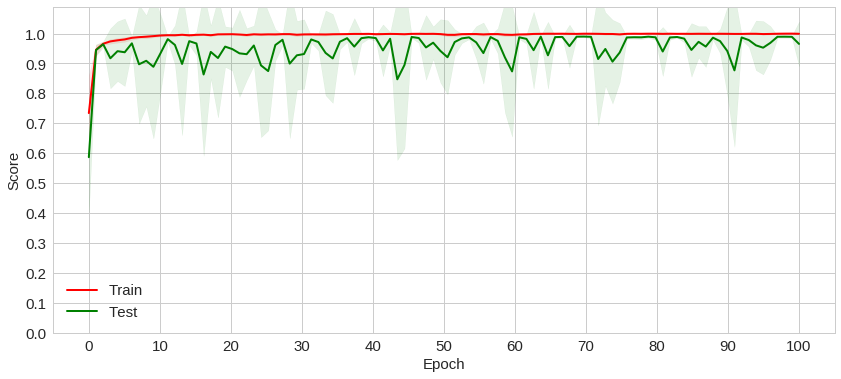

In [40]:
plot_mean_acc(hist)

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0]['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['loss']
    test_scores = np.zeros((len(history),len(history[0]['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_loss']
    epochs = np.linspace(0, len(history[0]['loss']), len(history[0]['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, alpha=0.7, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,-3.9,17.9))
    plt.show()

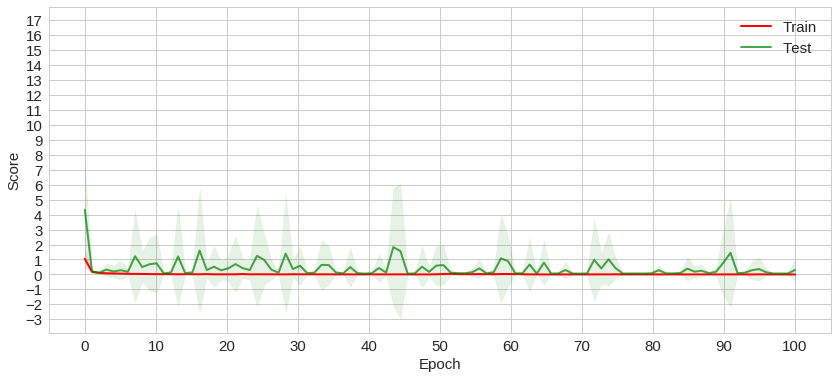

In [42]:
plot_mean_loss(hist)